**<font  size=6>日內走勢報告</font>**


In [1]:
# %%
import pandas as pd
import numpy as np
import pyodbc
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
import datetime
from interval3 import Interval, IntervalSet
from tqdm import tqdm
from importlib import reload
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import os

from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Users\chiehlinchen\Desktop\msj.ttf',size=14)
# sns.set(font=myfont.get_family(), rc={'figure.figsize':(5,4)}, font_scale= 2)
# sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams['axes.facecolor']='whitesmoke'

# %%
today = datetime.datetime.now().strftime("%Y%m%d")


# %%
class get_df:

    def __init__(self):
        self.DB_infos = {"X01" : ("192.168.1.16", "X01", "cm23357868", "86875332")}
        self.querys = {}
        self.db = str()
        self.df_dict =  dict()
        self.w_code_dict = dict()
        self.point_dict = dict()
        self.result_dict = dict()
        
    def db_connect(self, DB_info):
        DB_Host, DB_Name, DB_User, DB_Password = self.DB_infos[DB_info]
        print("Connecting to database using pyodbc...")
        self.db = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)
        print("Succesfully Connected to database using pyodbc!")
      
    def load_data(self, query):
        df =  pd.read_sql(self.querys[query], self.db)
        return df
    
    @staticmethod
    def make_stock_price():
        sql_stock_price = """SELECT  [日期]
                            ,[股票代號]
                            ,[成交量]
                            ,[成交金額(千)]
                            ,[開盤價]
                            ,[最高價]
                            ,[最低價]
                            ,[收盤價]
                            ,[漲幅(%)]
                        FROM [X01].[dbo].[日收盤還原表排行] where 日期 >= '20200101' and LEN(股票代號)=4 order by 日期 """
        return sql_stock_price
    @staticmethod
    def make_TWA00():
        sql_stock_price = """SELECT  [日期]
                            ,[股票代號]
                            ,[成交量]
                            ,[成交金額(千)]
                            ,[開盤價]
                            ,[最高價]
                            ,[最低價]
                            ,[收盤價]
                            ,[漲幅(%)]
                        FROM [X01].[dbo].[日收盤還原表排行]""" + "where 日期 >= '%s' and 股票代號='TWA00' order by 日期 "% today
        return sql_stock_price

    @staticmethod
    def make_TWA00_org():
        df = """SELECT   [日期]
                        ,[股票代號]
                        ,[收盤價]
                        ,[均價]
                    FROM [X01].[dbo].[日收盤表排行]""" "where 日期 >= '%s' and 股票代號='TWA00'  order by 日期 "% today
        return df


    @staticmethod
    def make_stock_price_org():
        df = """SELECT   [日期]
                        ,[股票代號]
                        ,[開盤價]
                        ,[收盤價]
                        ,[均價]
                    FROM [X01].[dbo].[日收盤表排行] where 日期 >= '20200101' and 日期 <= '20211231' and LEN(股票代號)=4 order by 日期 """
        return df

    @staticmethod
    def make_off():
        sql_off = """SELECT [股票代號]                                  
                                    FROM [X01].[dbo].[下市櫃公司基本資料]""" +  "where 年度 >='%s'" %today[:4]
        return sql_off

    @staticmethod
    def make_stock_ls():
        df ="""SELECT [股票代號]
                      FROM [X01].[dbo].[上市櫃公司基本資料]"""
        return df


    @staticmethod
    def make_stock_vol():
        df ="""SELECT [日期]
                        ,[股票代號]
                        ,[Beta係數(21D)]
                    FROM [X01].[dbo].[日常用技術指標表]"""+ "where 日期 >= '20191231' and 日期 <= '20211231' and LEN(股票代號)=4 order by 日期 "
        return df


    staticmethod
    def make_vix():
        df ="""SELECT [日期]
                        ,[收盤價]
                  FROM [X01].[dbo].[日台指選擇權波動率指數(收盤價)]"""+ "where 日期 >= '20191231' and 日期 <= '20211231' order by 日期 "
        return df

In [2]:
#獲取數據
Sql_Base = get_df()
Sql_Base.db_connect('X01')

Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


In [3]:
TCRI =list(pd.read_excel(r"C:\Users\chiehlinchen\Downloads\TCRINEW.xlsx")['NUM'].astype(str))

In [4]:
Sql_Base.querys['日收盤排行還原'] = get_df.make_stock_price_org()
df_org = Sql_Base.load_data('日收盤排行還原')

In [5]:
df_org = df_org[df_org['股票代號'].isin(TCRI)]
df_org.reset_index(drop = True,inplace= True)
df_org['收盤減開盤除開盤'] = (df_org['收盤價']-df_org['開盤價'])/df_org['開盤價']
df_org['開盤減收盤除開盤'] = (df_org['開盤價']-df_org['收盤價'])/df_org['開盤價']
df_org['收盤減開盤除開盤(加成本0.435%)'] = df_org['收盤減開盤除開盤']- 0.00435
df_org['開盤減收盤除開盤(加成本0.435%)'] = df_org['開盤減收盤除開盤']- 0.00435
df_org['收盤減開盤除開盤(加成本0.335%)'] = df_org['收盤減開盤除開盤']- 0.00335
df_org['開盤減收盤除開盤(加成本0.335%)'] = df_org['開盤減收盤除開盤']- 0.00335
df_org['收盤減開盤除開盤(加成本0.15%)'] = df_org['收盤減開盤除開盤']- 0.0015
df_org['開盤減收盤除開盤(加成本0.15%)'] = df_org['開盤減收盤除開盤']- 0.0015

In [6]:
df = df_org.groupby('日期').agg({'收盤減開盤除開盤':'mean','收盤減開盤除開盤(加成本0.435%)':'mean','收盤減開盤除開盤(加成本0.335%)':'mean'
                                ,'收盤減開盤除開盤(加成本0.15%)':'mean','開盤減收盤除開盤':'mean','開盤減收盤除開盤(加成本0.435%)':'mean','開盤減收盤除開盤(加成本0.335%)':'mean',
                                '開盤減收盤除開盤(加成本0.15%)':'mean'})
df['累積收盤減開盤除開盤'] = df['收盤減開盤除開盤'].cumsum()
df['累積收盤減開盤除開盤(加成本0.435%)'] = df['收盤減開盤除開盤(加成本0.435%)'].cumsum()
df['累積收盤減開盤除開盤(加成本0.335%)'] = df['收盤減開盤除開盤(加成本0.335%)'].cumsum()
df['累積收盤減開盤除開盤(加成本0.15%)'] = df['收盤減開盤除開盤(加成本0.15%)'].cumsum()
df['累積開盤減收盤除開盤'] = df['開盤減收盤除開盤'].cumsum()
df['累積開盤減收盤除開盤(加成本0.435%)'] = df['開盤減收盤除開盤(加成本0.435%)'].cumsum()
df['累積開盤減收盤除開盤(加成本0.335%)'] = df['開盤減收盤除開盤(加成本0.335%)'].cumsum()
df['累積開盤減收盤除開盤(加成本0.15%)'] = df['開盤減收盤除開盤(加成本0.15%)'].cumsum()

In [7]:
Sql_Base.querys['日台指選擇權波動率指數(收盤價)'] = get_df.make_vix()
df_vix = Sql_Base.load_data('日台指選擇權波動率指數(收盤價)')
df_vix['日期new'] = df_vix['日期'].shift(-1)
df_vix = df_vix.drop(columns='日期').rename(columns={'日期new':'日期'}).set_index('日期').reset_index(drop = False).dropna()
df_vix = df_vix[df_vix['收盤價']>=25]

In [8]:
Sql_Base.querys['日常用技術指標表'] = get_df.make_stock_vol()
df_vol = Sql_Base.load_data('日常用技術指標表')
df_vol['日期shift'] = df_vol.groupby('股票代號').shift(-1)['日期']
df_vol = df_vol.drop(columns = '日期').rename(columns={'日期shift':'日期'}).set_index('日期').reset_index(drop = False).dropna()
df_vol = df_vol[df_vol['股票代號'].isin(TCRI)].reset_index(drop = True)
df_vol = df_vol[df_vol['Beta係數(21D)']>1.5].reset_index(drop = True)

In [9]:
df_vol = df_vol.merge(df_org,how = 'left')
df_vol_day = df_vol.groupby('日期').agg({'收盤減開盤除開盤':'mean','收盤減開盤除開盤(加成本0.435%)':'mean','收盤減開盤除開盤(加成本0.335%)':'mean'
                                ,'收盤減開盤除開盤(加成本0.15%)':'mean','開盤減收盤除開盤':'mean','開盤減收盤除開盤(加成本0.435%)':'mean','開盤減收盤除開盤(加成本0.335%)':'mean',
                                '開盤減收盤除開盤(加成本0.15%)':'mean'})
df_vol_day['累積收盤減開盤除開盤'] = df_vol_day['收盤減開盤除開盤'].cumsum()
df_vol_day['累積收盤減開盤除開盤(加成本0.435%)'] = df_vol_day['收盤減開盤除開盤(加成本0.435%)'].cumsum()
df_vol_day['累積收盤減開盤除開盤(加成本0.335%)'] = df_vol_day['收盤減開盤除開盤(加成本0.335%)'].cumsum()
df_vol_day['累積收盤減開盤除開盤(加成本0.15%)'] = df_vol_day['收盤減開盤除開盤(加成本0.15%)'].cumsum()
df_vol_day['累積開盤減收盤除開盤'] = df_vol_day['開盤減收盤除開盤'].cumsum()
df_vol_day['累積開盤減收盤除開盤(加成本0.435%)'] = df_vol_day['開盤減收盤除開盤(加成本0.435%)'].cumsum()
df_vol_day['累積開盤減收盤除開盤(加成本0.335%)'] = df_vol_day['開盤減收盤除開盤(加成本0.335%)'].cumsum()
df_vol_day['累積開盤減收盤除開盤(加成本0.15%)'] = df_vol_day['開盤減收盤除開盤(加成本0.15%)'].cumsum()

In [10]:
pool_long = pd.read_csv(r'Z:\07個人\ChiehLin\回測股票池\新股票池_多.csv',index_col= 0)
pool_short = pd.read_csv(r'Z:\07個人\ChiehLin\回測股票池\新股票池_空.csv',index_col= 0)

In [11]:
pool_long = pd.read_csv(r'Z:\07個人\ChiehLin\回測股票池\新股票池_多.csv',index_col= 0)
pool_long = pd.DataFrame(pool_long.T.unstack()).reset_index(drop = False).drop(columns = 'level_1').rename(columns={'level_0':'日期',0:'股票代號'})
pool_long['日期'] = pool_long['日期'].astype(str)
pool_long['股票代號'] = pool_long['股票代號'].astype(str)
pool_long = pool_long.merge(df_org, on = ['日期','股票代號'],how = 'left')
pool_long_day = pool_long.groupby('日期').agg({'收盤減開盤除開盤':'mean','收盤減開盤除開盤(加成本0.435%)':'mean','收盤減開盤除開盤(加成本0.335%)':'mean'
                                ,'收盤減開盤除開盤(加成本0.15%)':'mean','開盤減收盤除開盤':'mean','開盤減收盤除開盤(加成本0.435%)':'mean','開盤減收盤除開盤(加成本0.335%)':'mean',
                                '開盤減收盤除開盤(加成本0.15%)':'mean'})
pool_long_day['累積收盤減開盤除開盤'] = pool_long_day['收盤減開盤除開盤'].cumsum()
pool_long_day['累積收盤減開盤除開盤(加成本0.435%)'] = pool_long_day['收盤減開盤除開盤(加成本0.435%)'].cumsum()
pool_long_day['累積收盤減開盤除開盤(加成本0.335%)'] = pool_long_day['收盤減開盤除開盤(加成本0.335%)'].cumsum()
pool_long_day['累積收盤減開盤除開盤(加成本0.15%)'] = pool_long_day['收盤減開盤除開盤(加成本0.15%)'].cumsum()
pool_long_day['累積開盤減收盤除開盤'] = pool_long_day['開盤減收盤除開盤'].cumsum()
pool_long_day['累積開盤減收盤除開盤(加成本0.435%)'] = pool_long_day['開盤減收盤除開盤(加成本0.435%)'].cumsum()
pool_long_day['累積開盤減收盤除開盤(加成本0.335%)'] = pool_long_day['開盤減收盤除開盤(加成本0.335%)'].cumsum()
pool_long_day['累積開盤減收盤除開盤(加成本0.15%)'] = pool_long_day['開盤減收盤除開盤(加成本0.15%)'].cumsum()

In [12]:
pool_short = pd.read_csv(r'Z:\07個人\ChiehLin\回測股票池\新股票池_空.csv',index_col= 0)
pool_short = pd.DataFrame(pool_short.T.unstack()).reset_index(drop = False).drop(columns = 'level_1').rename(columns={'level_0':'日期',0:'股票代號'})
pool_short['日期'] = pool_short['日期'].astype(str)
pool_short['股票代號'] = pool_short['股票代號'].astype(str)
pool_short = pool_short.merge(df_org, on = ['日期','股票代號'],how = 'left')
pool_short_day = pool_short.groupby('日期').agg({'收盤減開盤除開盤':'mean','收盤減開盤除開盤(加成本0.435%)':'mean','收盤減開盤除開盤(加成本0.335%)':'mean'
                                ,'收盤減開盤除開盤(加成本0.15%)':'mean','開盤減收盤除開盤':'mean','開盤減收盤除開盤(加成本0.435%)':'mean','開盤減收盤除開盤(加成本0.335%)':'mean',
                                '開盤減收盤除開盤(加成本0.15%)':'mean'})
pool_short_day['累積收盤減開盤除開盤'] = pool_short_day['收盤減開盤除開盤'].cumsum()
pool_short_day['累積收盤減開盤除開盤(加成本0.435%)'] = pool_short_day['收盤減開盤除開盤(加成本0.435%)'].cumsum()
pool_short_day['累積收盤減開盤除開盤(加成本0.335%)'] = pool_short_day['收盤減開盤除開盤(加成本0.335%)'].cumsum()
pool_short_day['累積收盤減開盤除開盤(加成本0.15%)'] = pool_short_day['收盤減開盤除開盤(加成本0.15%)'].cumsum()
pool_short_day['累積開盤減收盤除開盤'] = pool_short_day['開盤減收盤除開盤'].cumsum()
pool_short_day['累積開盤減收盤除開盤(加成本0.435%)'] = pool_short_day['開盤減收盤除開盤(加成本0.435%)'].cumsum()
pool_short_day['累積開盤減收盤除開盤(加成本0.335%)'] = pool_short_day['開盤減收盤除開盤(加成本0.335%)'].cumsum()
pool_short_day['累積開盤減收盤除開盤(加成本0.15%)'] = pool_short_day['開盤減收盤除開盤(加成本0.15%)'].cumsum()

In [13]:
pool_combine = pool_short_day[['開盤減收盤除開盤(加成本0.435%)','開盤減收盤除開盤(加成本0.335%)','開盤減收盤除開盤(加成本0.15%)']].merge(pool_long_day[['收盤減開盤除開盤(加成本0.435%)','收盤減開盤除開盤(加成本0.335%)','收盤減開盤除開盤(加成本0.15%)']], left_index= True, right_index= True)
pool_combine = pool_combine.reset_index(drop = False)
pool_combine['多單損益(加成本0.435%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),pool_combine['收盤減開盤除開盤(加成本0.435%)'],0)
pool_combine['多單損益(加成本0.335%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),pool_combine['收盤減開盤除開盤(加成本0.335%)'],0)
pool_combine['多單損益(加成本0.15%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),pool_combine['收盤減開盤除開盤(加成本0.15%)'],0)
pool_combine['空單損益(加成本0.435%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),0,pool_combine['開盤減收盤除開盤(加成本0.435%)'])
pool_combine['空單損益(加成本0.335%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),0,pool_combine['開盤減收盤除開盤(加成本0.335%)'])
pool_combine['空單損益(加成本0.15%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),0,pool_combine['開盤減收盤除開盤(加成本0.15%)'])
pool_combine['組合損益(加成本0.435%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),pool_combine['收盤減開盤除開盤(加成本0.435%)'],pool_combine['開盤減收盤除開盤(加成本0.435%)'])
pool_combine['組合損益(加成本0.335%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),pool_combine['收盤減開盤除開盤(加成本0.335%)'],pool_combine['開盤減收盤除開盤(加成本0.335%)'])
pool_combine['組合損益(加成本0.15%)'] = np.where(pool_combine['日期'].isin(df_vix['日期']),pool_combine['收盤減開盤除開盤(加成本0.15%)'],pool_combine['開盤減收盤除開盤(加成本0.15%)'])
pool_combine = pool_combine.set_index('日期')
pool_combine['累積多單損益(加成本0.435%)'] = pool_combine['多單損益(加成本0.435%)'].cumsum()
pool_combine['累積多單損益(加成本0.335%)'] = pool_combine['多單損益(加成本0.335%)'].cumsum()
pool_combine['累積多單損益(加成本0.15%)'] = pool_combine['多單損益(加成本0.15%)'].cumsum()
pool_combine['累積空單損益(加成本0.435%)'] = pool_combine['空單損益(加成本0.435%)'].cumsum()
pool_combine['累積空單損益(加成本0.335%)'] = pool_combine['空單損益(加成本0.335%)'].cumsum()
pool_combine['累積空單損益(加成本0.15%)'] = pool_combine['空單損益(加成本0.15%)'].cumsum()
pool_combine['累積組合損益(加成本0.435%)'] = pool_combine['組合損益(加成本0.435%)'].cumsum()
pool_combine['累積組合損益(加成本0.335%)'] = pool_combine['組合損益(加成本0.335%)'].cumsum()
pool_combine['累積組合損益(加成本0.15%)'] = pool_combine['組合損益(加成本0.15%)'].cumsum()

In [14]:
df_org = df_org.rename(columns ={"收盤減開盤除開盤":"全市場多單報酬率","開盤減收盤除開盤":"全市場空單報酬率",
                        "收盤減開盤除開盤(加成本0.435%)":"全市場多單報酬率(加成本0.435%)","收盤減開盤除開盤(加成本0.335%)":"全市場多單報酬率(加成本0.335%)","收盤減開盤除開盤(加成本0.15%)":"全市場多單報酬率(加成本0.15%)",
                        "開盤減收盤除開盤(加成本0.435%)":"全市場空單報酬率(加成本0.435%)","開盤減收盤除開盤(加成本0.335%)":"全市場空單報酬率(加成本0.335%)","開盤減收盤除開盤(加成本0.15%)":"全市場空單報酬率(加成本0.15%)"})

In [15]:
df = df.rename(columns ={"收盤減開盤除開盤":"全市場多單報酬率","開盤減收盤除開盤":"全市場空單報酬率",
                        "收盤減開盤除開盤(加成本0.435%)":"全市場多單報酬率(加成本0.435%)","收盤減開盤除開盤(加成本0.335%)":"全市場多單報酬率(加成本0.335%)","收盤減開盤除開盤(加成本0.15%)":"全市場多單報酬率(加成本0.15%)",
                        "開盤減收盤除開盤(加成本0.435%)":"全市場空單報酬率(加成本0.435%)","開盤減收盤除開盤(加成本0.335%)":"全市場空單報酬率(加成本0.335%)","開盤減收盤除開盤(加成本0.15%)":"全市場空單報酬率(加成本0.15%)",
                    "累積收盤減開盤除開盤":"累積全市場多單報酬率","累積開盤減收盤除開盤":"累積全市場空單報酬率",
                        "累積收盤減開盤除開盤(加成本0.435%)":"累積全市場多單報酬率(加成本0.435%)","累積收盤減開盤除開盤(加成本0.335%)":"累積全市場多單報酬率(加成本0.335%)","累積收盤減開盤除開盤(加成本0.15%)":"累積全市場多單報酬率(加成本0.15%)",
                        "累積開盤減收盤除開盤(加成本0.435%)":"累積全市場空單報酬率(加成本0.435%)","累積開盤減收盤除開盤(加成本0.335%)":"累積全市場空單報酬率(加成本0.335%)","累積開盤減收盤除開盤(加成本0.15%)":"累積全市場空單報酬率(加成本0.15%)"})

In [16]:
df_vol = df_vol.rename(columns ={"收盤減開盤除開盤":"Beta>1.5多單報酬率","開盤減收盤除開盤":"Beta>1.5空單報酬率",
                        "收盤減開盤除開盤(加成本0.435%)":"Beta>1.5多單報酬率(加成本0.435%)","收盤減開盤除開盤(加成本0.335%)":"Beta>1.5多單報酬率(加成本0.335%)","收盤減開盤除開盤(加成本0.15%)":"Beta>1.5多單報酬率(加成本0.15%)",
                        "開盤減收盤除開盤(加成本0.435%)":"Beta>1.5空單報酬率(加成本0.435%)","開盤減收盤除開盤(加成本0.335%)":"Beta>1.5空單報酬率(加成本0.335%)","開盤減收盤除開盤(加成本0.15%)":"Beta>1.5空單報酬率(加成本0.15%)"})

In [17]:
df_vol_day = df_vol_day.rename(columns ={"收盤減開盤除開盤":"Beta>1.5多單報酬率","開盤減收盤除開盤":"Beta>1.5空單報酬率",
                        "收盤減開盤除開盤(加成本0.435%)":"Beta>1.5多單報酬率(加成本0.435%)","收盤減開盤除開盤(加成本0.335%)":"Beta>1.5多單報酬率(加成本0.335%)","收盤減開盤除開盤(加成本0.15%)":"Beta>1.5多單報酬率(加成本0.15%)",
                        "開盤減收盤除開盤(加成本0.435%)":"Beta>1.5空單報酬率(加成本0.435%)","開盤減收盤除開盤(加成本0.335%)":"Beta>1.5空單報酬率(加成本0.335%)","開盤減收盤除開盤(加成本0.15%)":"Beta>1.5空單報酬率(加成本0.15%)",
                    "累積收盤減開盤除開盤":"累積Beta>1.5多單報酬率","累積開盤減收盤除開盤":"累積Beta>1.5空單報酬率",
                        "累積收盤減開盤除開盤(加成本0.435%)":"累積Beta>1.5多單報酬率(加成本0.435%)","累積收盤減開盤除開盤(加成本0.335%)":"累積Beta>1.5多單報酬率(加成本0.335%)","累積收盤減開盤除開盤(加成本0.15%)":"累積Beta>1.5多單報酬率(加成本0.15%)",
                        "累積開盤減收盤除開盤(加成本0.435%)":"累積Beta>1.5空單報酬率(加成本0.435%)","累積開盤減收盤除開盤(加成本0.335%)":"累積Beta>1.5空單報酬率(加成本0.335%)","累積開盤減收盤除開盤(加成本0.15%)":"累積Beta>1.5空單報酬率(加成本0.15%)"})

In [18]:
pool_long = pool_long.rename(columns ={"收盤減開盤除開盤":"選股後多單報酬率","開盤減收盤除開盤":"選股後空單報酬率",
                        "收盤減開盤除開盤(加成本0.435%)":"選股後多單報酬率(加成本0.435%)","收盤減開盤除開盤(加成本0.335%)":"選股後多單報酬率(加成本0.335%)","收盤減開盤除開盤(加成本0.15%)":"選股後多單報酬率(加成本0.15%)",
                        "開盤減收盤除開盤(加成本0.435%)":"選股後空單報酬率(加成本0.435%)","開盤減收盤除開盤(加成本0.335%)":"選股後空單報酬率(加成本0.335%)","開盤減收盤除開盤(加成本0.15%)":"選股後空單報酬率(加成本0.15%)"})

In [19]:
pool_long_day= pool_long_day.rename(columns ={"收盤減開盤除開盤":"選股後多單報酬率","開盤減收盤除開盤":"選股後空單報酬率",
                        "收盤減開盤除開盤(加成本0.435%)":"選股後多單報酬率(加成本0.435%)","收盤減開盤除開盤(加成本0.335%)":"選股後多單報酬率(加成本0.335%)","收盤減開盤除開盤(加成本0.15%)":"選股後多單報酬率(加成本0.15%)",
                        "開盤減收盤除開盤(加成本0.435%)":"選股後空單報酬率(加成本0.435%)","開盤減收盤除開盤(加成本0.335%)":"選股後空單報酬率(加成本0.335%)","開盤減收盤除開盤(加成本0.15%)":"選股後空單報酬率(加成本0.15%)",
                    "累積收盤減開盤除開盤":"累積選股後多單報酬率","累積開盤減收盤除開盤":"累積選股後空單報酬率",
                        "累積收盤減開盤除開盤(加成本0.435%)":"累積選股後多單報酬率(加成本0.435%)","累積收盤減開盤除開盤(加成本0.335%)":"累積選股後多單報酬率(加成本0.335%)","累積收盤減開盤除開盤(加成本0.15%)":"累積選股後多單報酬率(加成本0.15%)",
                        "累積開盤減收盤除開盤(加成本0.435%)":"累積選股後空單報酬率(加成本0.435%)","累積開盤減收盤除開盤(加成本0.335%)":"累積選股後空單報酬率(加成本0.335%)","累積開盤減收盤除開盤(加成本0.15%)":"累積選股後空單報酬率(加成本0.15%)"})

In [20]:
pool_short = pool_short.rename(columns ={"收盤減開盤除開盤":"選股後多單報酬率","開盤減收盤除開盤":"選股後空單報酬率",
                        "收盤減開盤除開盤(加成本0.435%)":"選股後多單報酬率(加成本0.435%)","收盤減開盤除開盤(加成本0.335%)":"選股後多單報酬率(加成本0.335%)","收盤減開盤除開盤(加成本0.15%)":"選股後多單報酬率(加成本0.15%)",
                        "開盤減收盤除開盤(加成本0.435%)":"選股後空單報酬率(加成本0.435%)","開盤減收盤除開盤(加成本0.335%)":"選股後空單報酬率(加成本0.335%)","開盤減收盤除開盤(加成本0.15%)":"選股後空單報酬率(加成本0.15%)"})

In [21]:
pool_short_day= pool_short_day.rename(columns ={"收盤減開盤除開盤":"選股後多單報酬率","開盤減收盤除開盤":"選股後空單報酬率",
                        "收盤減開盤除開盤(加成本0.435%)":"選股後多單報酬率(加成本0.435%)","收盤減開盤除開盤(加成本0.335%)":"選股後多單報酬率(加成本0.335%)","收盤減開盤除開盤(加成本0.15%)":"選股後多單報酬率(加成本0.15%)",
                        "開盤減收盤除開盤(加成本0.435%)":"選股後空單報酬率(加成本0.435%)","開盤減收盤除開盤(加成本0.335%)":"選股後空單報酬率(加成本0.335%)","開盤減收盤除開盤(加成本0.15%)":"選股後空單報酬率(加成本0.15%)",
                    "累積收盤減開盤除開盤":"累積選股後多單報酬率","累積開盤減收盤除開盤":"累積選股後空單報酬率",
                        "累積收盤減開盤除開盤(加成本0.435%)":"累積選股後多單報酬率(加成本0.435%)","累積收盤減開盤除開盤(加成本0.335%)":"累積選股後多單報酬率(加成本0.335%)","累積收盤減開盤除開盤(加成本0.15%)":"累積選股後多單報酬率(加成本0.15%)",
                        "累積開盤減收盤除開盤(加成本0.435%)":"累積選股後空單報酬率(加成本0.435%)","累積開盤減收盤除開盤(加成本0.335%)":"累積選股後空單報酬率(加成本0.335%)","累積開盤減收盤除開盤(加成本0.15%)":"累積選股後空單報酬率(加成本0.15%)"})

**<font  size=5>原始分配</font>**

**<font  size=4>開盤進收盤出，做多單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

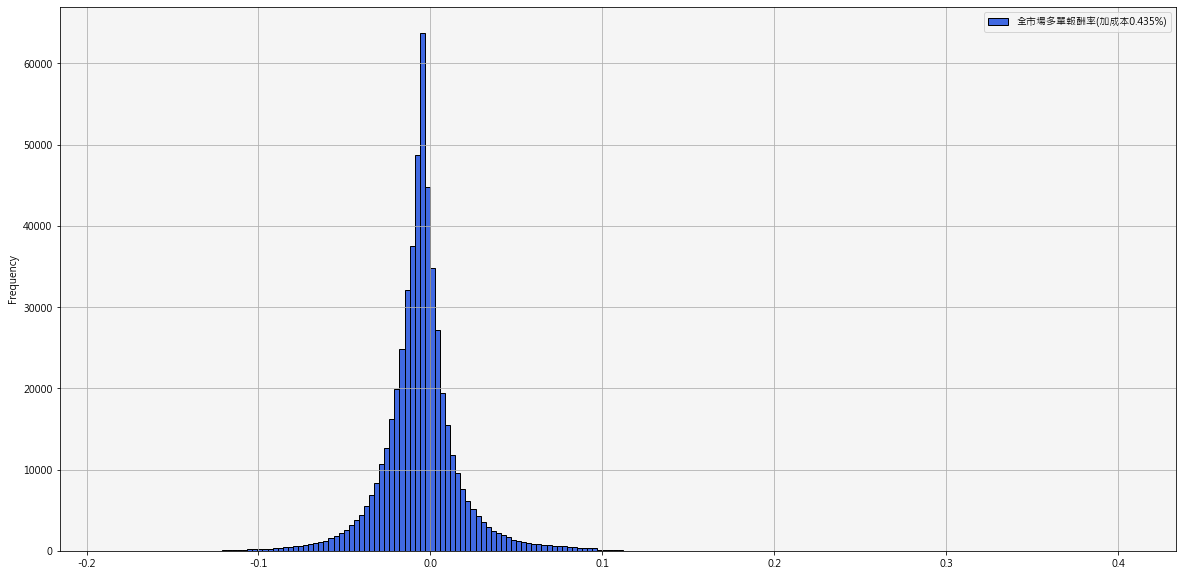

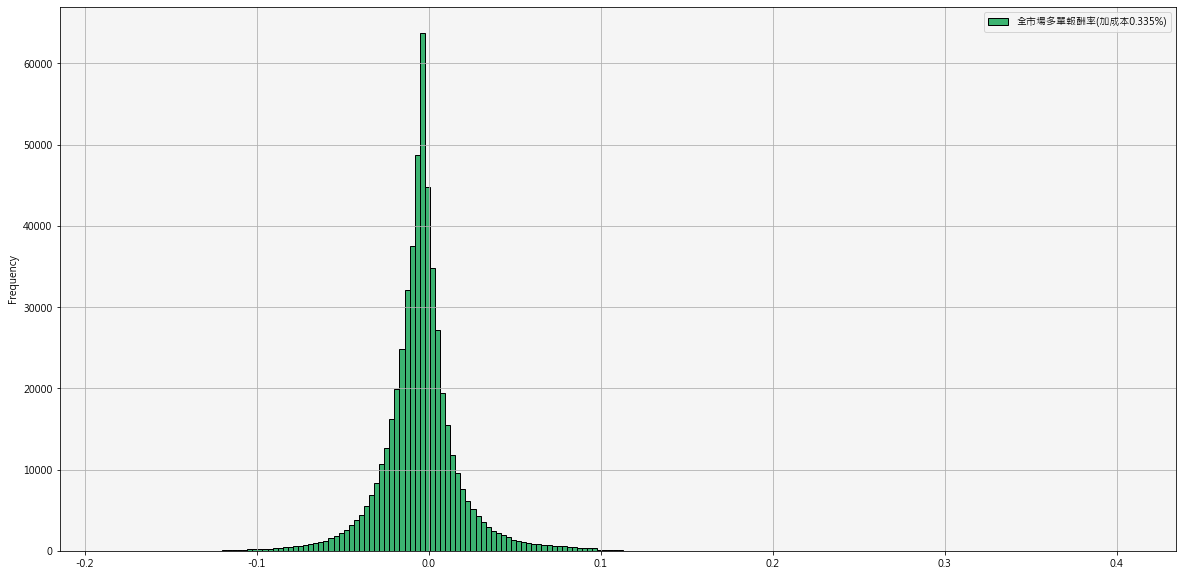

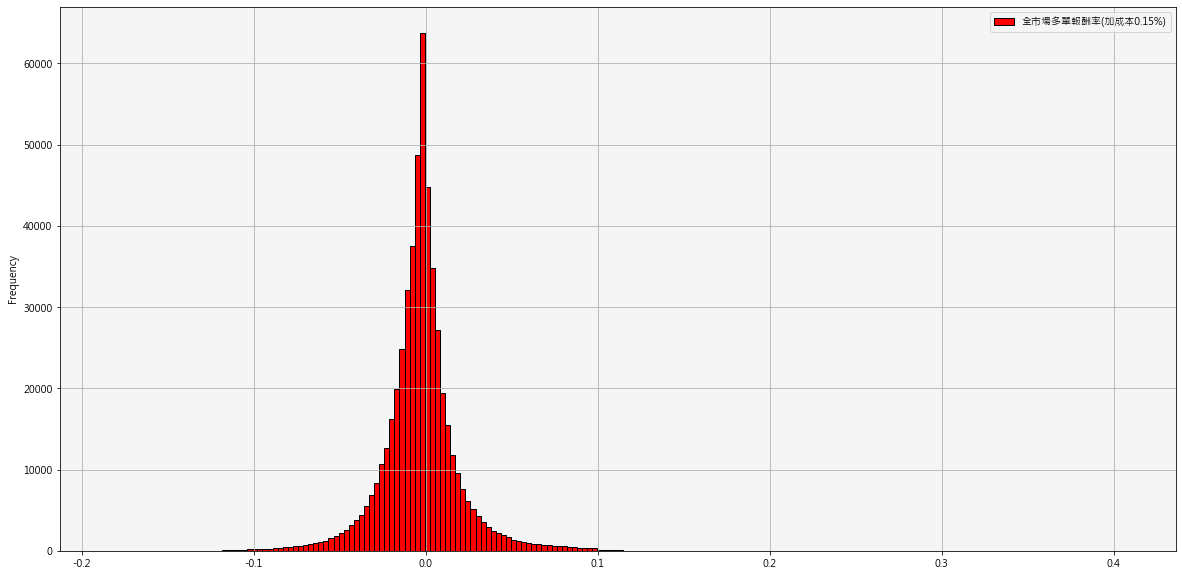

In [22]:
############################################################################################
#每日每股損益分配
#全市場
############################################################################################
df_org.set_index('日期')[['全市場多單報酬率(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
df_org.set_index('日期')[['全市場多單報酬率(加成本0.335%)']].plot.hist(edgecolor='black',facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
df_org.set_index('日期')[['全市場多單報酬率(加成本0.15%)']].plot.hist(edgecolor='black',facecolor = 'red',figsize = (20,10),bins=200,grid = True)

In [23]:
df_org.set_index('日期')[['全市場多單報酬率(加成本0.435%)','全市場多單報酬率(加成本0.335%)','全市場多單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,全市場多單報酬率(加成本0.435%),全市場多單報酬率(加成本0.335%),全市場多單報酬率(加成本0.15%)
mean,-0.005758,-0.004758,-0.002908
std,0.022208,0.022208,0.022208
min,-0.186168,-0.185168,-0.183318
25%,-0.015236,-0.014236,-0.012386
50%,-0.005521,-0.004521,-0.002671
75%,0.002759,0.003759,0.005609
max,0.403731,0.404731,0.406581


<AxesSubplot: ylabel='Frequency'>

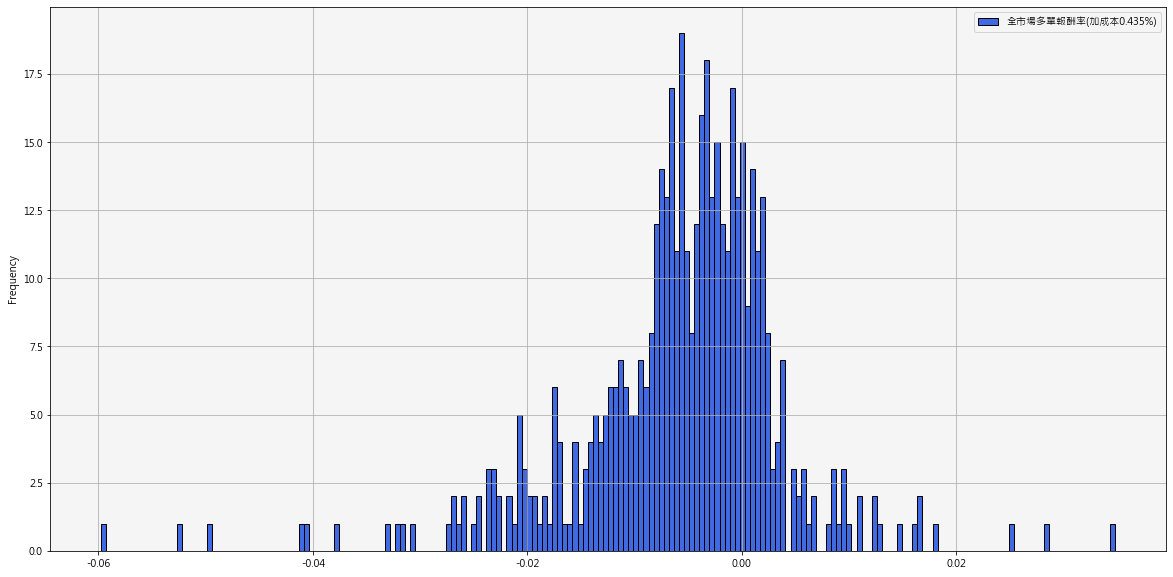

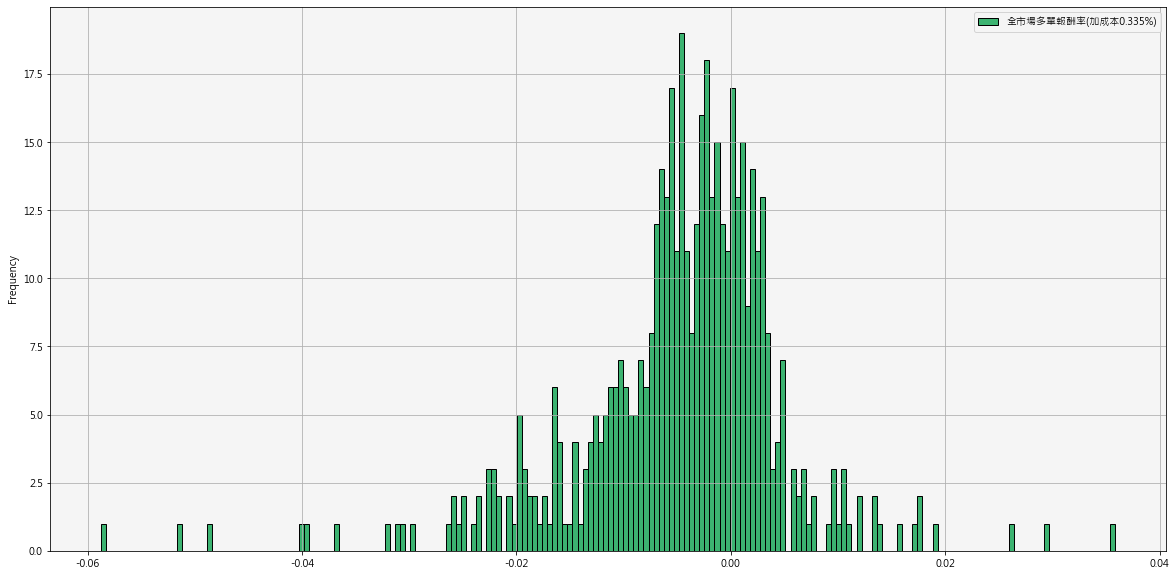

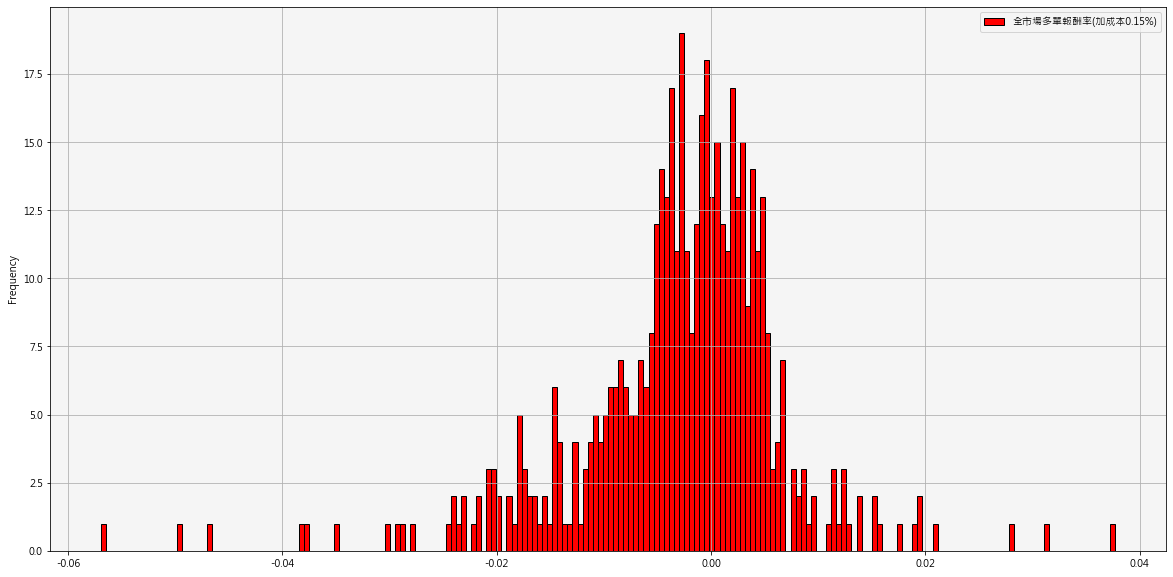

In [24]:
############################################################################################
#每日平均損益分配
#全市場
############################################################################################
df[['全市場多單報酬率(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=200,grid = True)
df[['全市場多單報酬率(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=200,grid = True)
df[['全市場多單報酬率(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=200,grid = True)

In [25]:
df[['全市場多單報酬率(加成本0.435%)','全市場多單報酬率(加成本0.335%)','全市場多單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,全市場多單報酬率(加成本0.435%),全市場多單報酬率(加成本0.335%),全市場多單報酬率(加成本0.15%)
mean,-0.005754,-0.004754,-0.002904
std,0.009639,0.009639,0.009639
min,-0.059790,-0.058790,-0.056940
25%,-0.009311,-0.008311,-0.006461
50%,-0.004426,-0.003426,-0.001576
75%,-0.000356,0.000644,0.002494
max,0.034854,0.035854,0.037704


<AxesSubplot: xlabel='日期'>

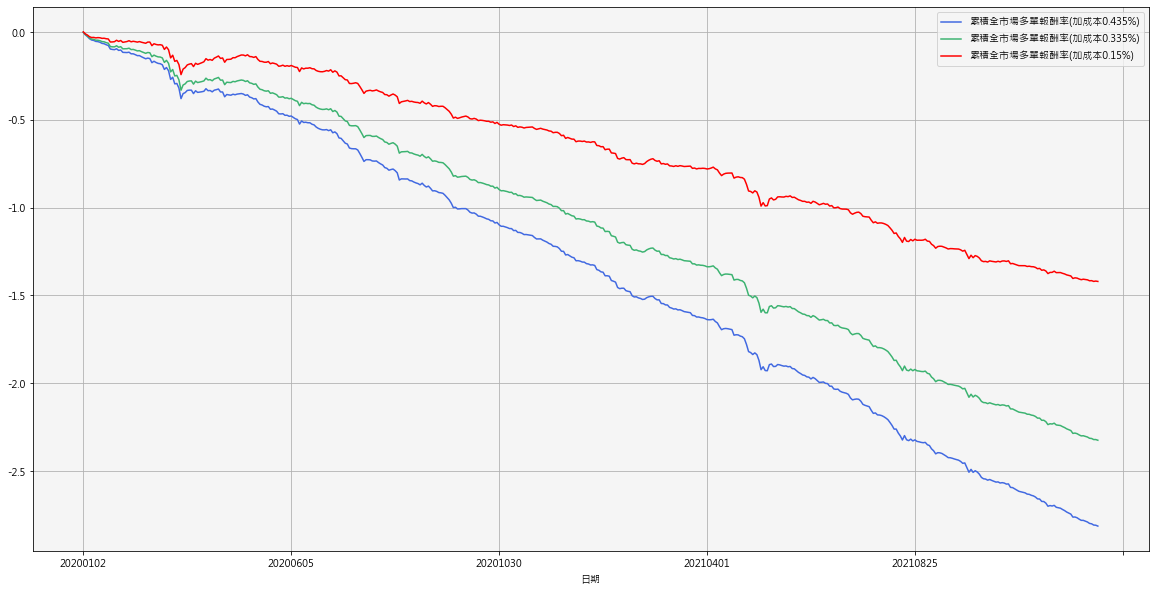

In [26]:
df[['累積全市場多單報酬率(加成本0.435%)','累積全市場多單報酬率(加成本0.335%)','累積全市場多單報酬率(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=4>開盤賣收盤回補，做空單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

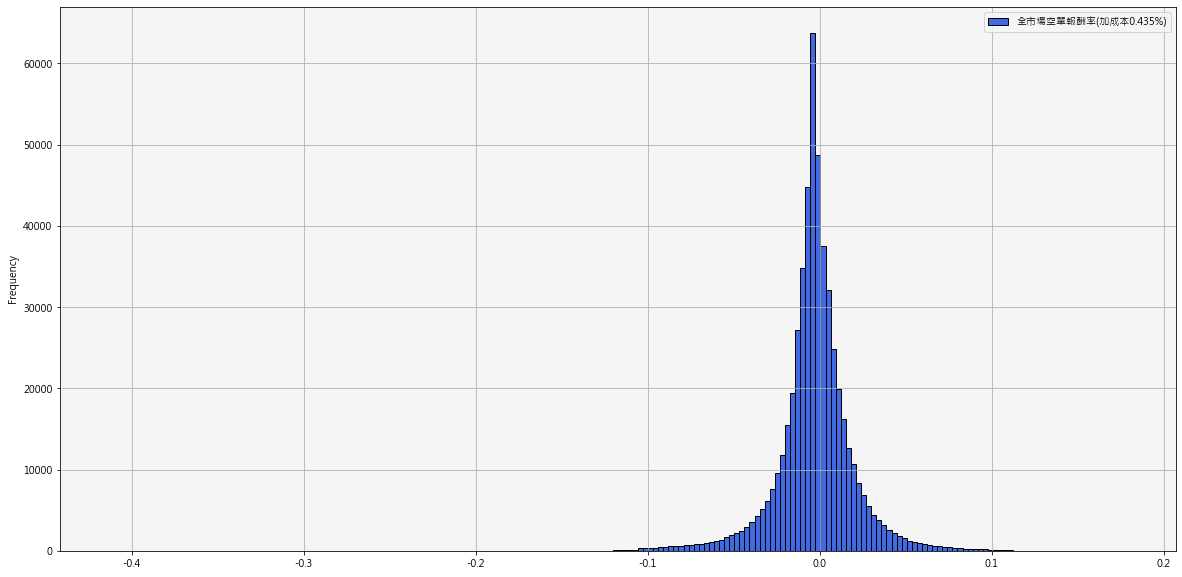

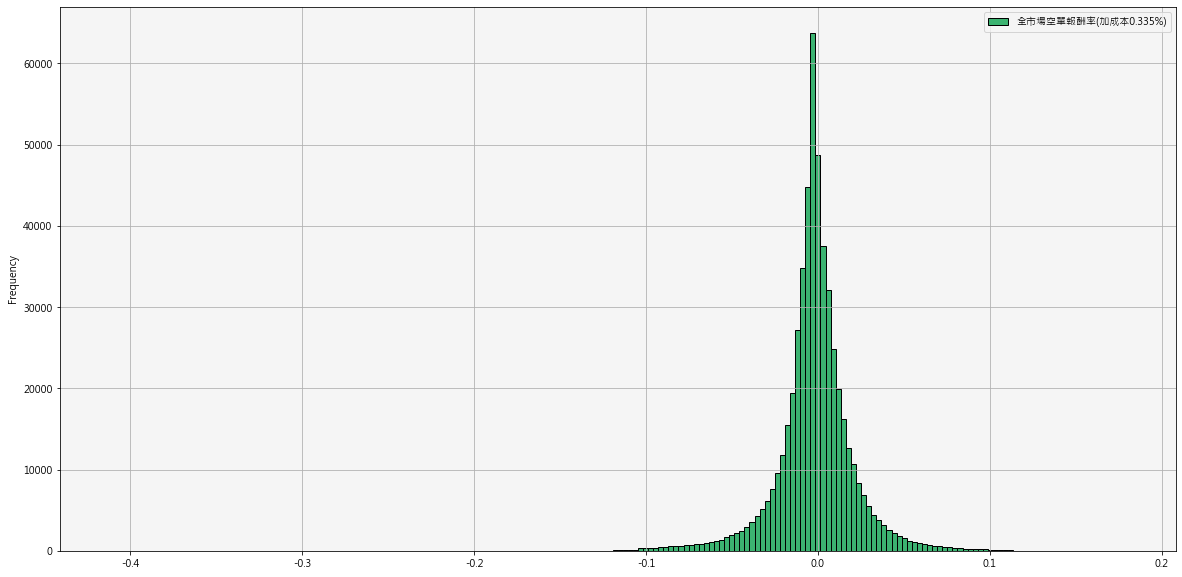

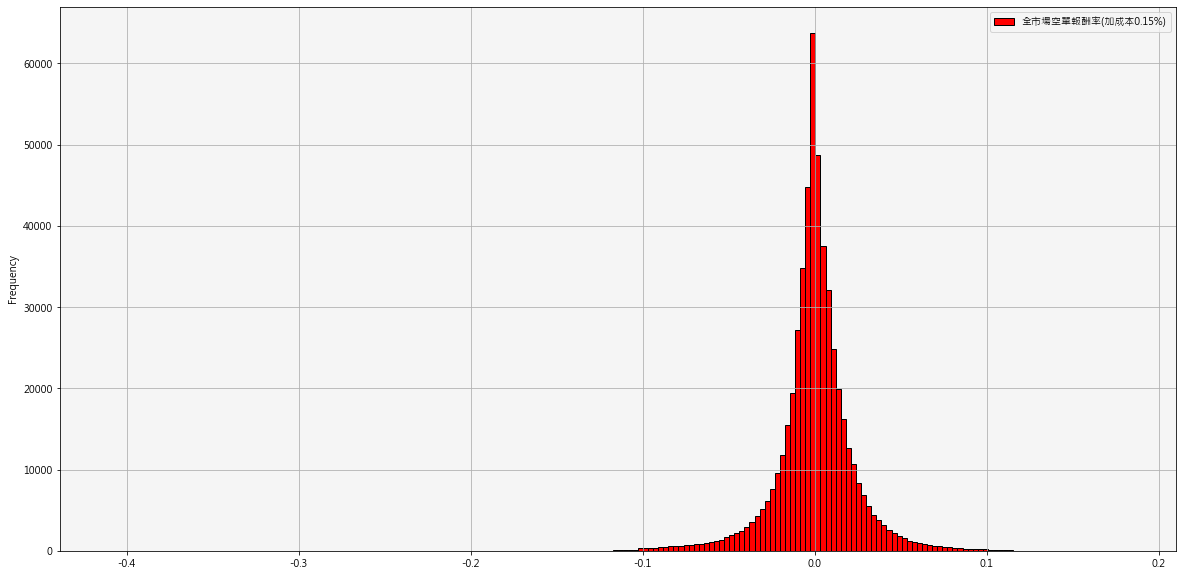

In [27]:
############################################################################################
#每日每股損益分配
#全市場
############################################################################################
df_org.set_index('日期')[['全市場空單報酬率(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
df_org.set_index('日期')[['全市場空單報酬率(加成本0.335%)']].plot.hist(edgecolor='black',facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
df_org.set_index('日期')[['全市場空單報酬率(加成本0.15%)']].plot.hist(edgecolor='black',facecolor = 'red',figsize = (20,10),bins=200,grid = True)

In [28]:
df_org.set_index('日期')[['全市場空單報酬率(加成本0.435%)','全市場空單報酬率(加成本0.335%)','全市場空單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,全市場空單報酬率(加成本0.435%),全市場空單報酬率(加成本0.335%),全市場空單報酬率(加成本0.15%)
mean,-0.002942,-0.001942,-0.000092
std,0.022208,0.022208,0.022208
min,-0.412431,-0.411431,-0.409581
25%,-0.011459,-0.010459,-0.008609
50%,-0.003179,-0.002179,-0.000329
75%,0.006536,0.007536,0.009386
max,0.177468,0.178468,0.180318


<AxesSubplot: ylabel='Frequency'>

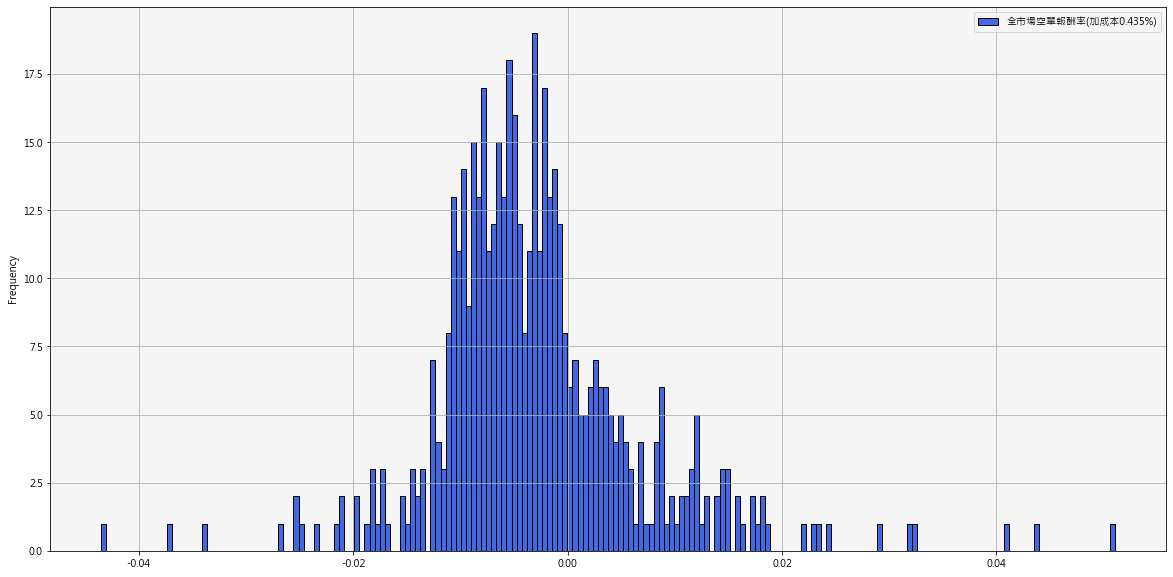

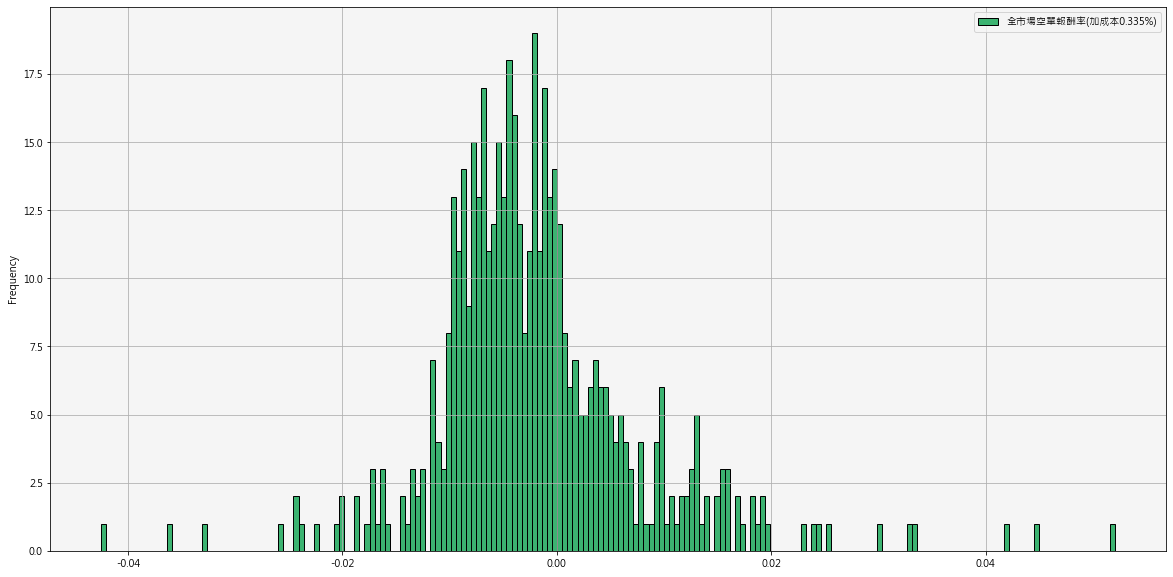

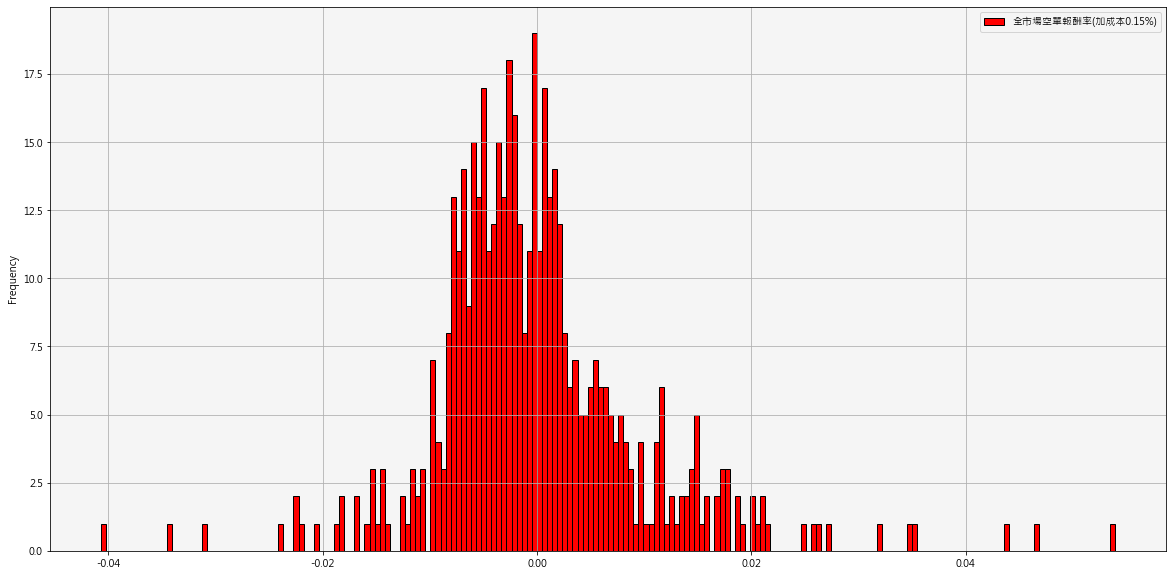

In [29]:
############################################################################################
#每日平均損益分配
#全市場
############################################################################################
df[['全市場空單報酬率(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=200,grid = True)
df[['全市場空單報酬率(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=200,grid = True)
df[['全市場空單報酬率(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=200,grid = True)

In [30]:
df[['全市場空單報酬率(加成本0.435%)','全市場空單報酬率(加成本0.335%)','全市場空單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,全市場空單報酬率(加成本0.435%),全市場空單報酬率(加成本0.335%),全市場空單報酬率(加成本0.15%)
mean,-0.002946,-0.001946,-0.000096
std,0.009639,0.009639,0.009639
min,-0.043554,-0.042554,-0.040704
25%,-0.008344,-0.007344,-0.005494
50%,-0.004274,-0.003274,-0.001424
75%,0.000611,0.001611,0.003461
max,0.051090,0.052090,0.053940


<AxesSubplot: xlabel='日期'>

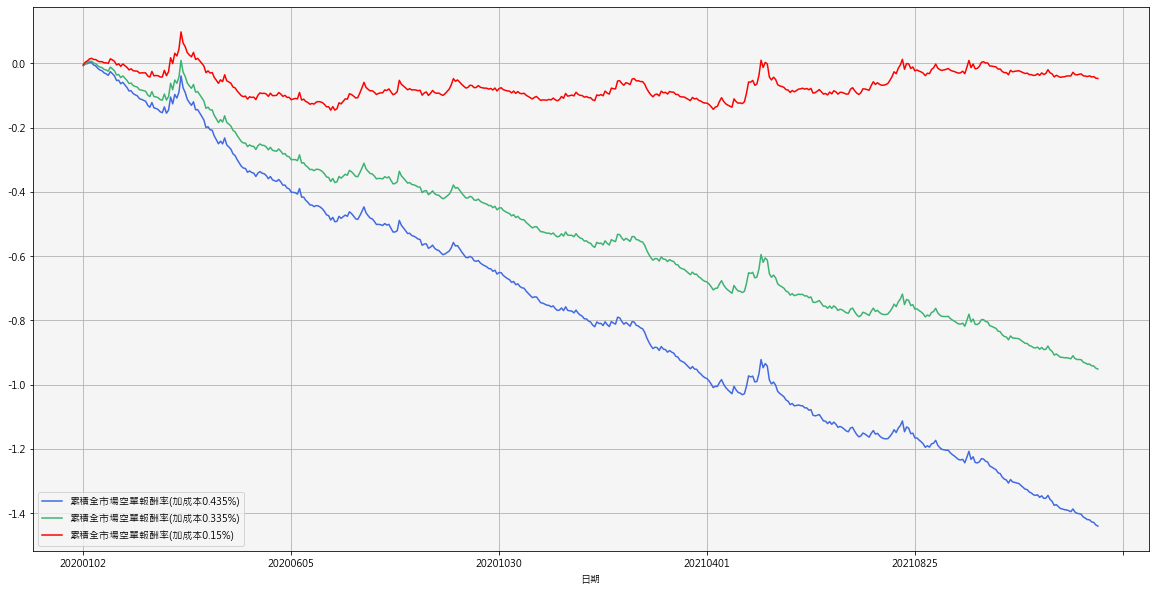

In [31]:
df[['累積全市場空單報酬率(加成本0.435%)','累積全市場空單報酬率(加成本0.335%)','累積全市場空單報酬率(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=5>Beta篩選後分配</font>**

**<font  size=4>每日檔數</font>**

In [32]:
df_vol.groupby('日期').count()[['股票代號']].T

日期,20200102,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,20200116,20200117,20200120,20200130,20200131,20200203,20200204,20200205,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,20200220,20200221,20200224,20200225,20200226,20200227,20200302,20200303,20200304,20200305,20200306,20200309,20200310,20200311,20200312,20200313,20200316,20200317,20200318,20200319,20200320,20200323,20200324,20200325,20200326,20200327,20200330,20200331,20200401,20200406,20200407,20200408,20200409,20200410,20200413,20200414,20200415,20200416,20200417,20200420,20200421,20200422,20200423,20200424,20200427,20200428,20200429,...,20210914,20210915,20210916,20210917,20210922,20210923,20210924,20210927,20210928,20210929,20210930,20211001,20211004,20211005,20211006,20211007,20211008,20211012,20211013,20211014,20211015,20211018,20211019,20211020,20211021,20211022,20211025,20211026,20211027,20211028,20211029,20211101,20211102,20211103,20211104,20211105,20211108,20211109,20211110,20211111,20211112,20211115,20211116,20211117,20211118,20211119,20211122,20211123,20211124,20211125,20211126,20211129,20211130,20211201,20211202,20211203,20211206,20211207,20211208,20211209,20211210,20211213,20211214,20211215,20211216,20211217,20211220,20211221,20211222,20211223,20211224,20211227,20211228,20211229,20211230
股票代號,80,76,67,71,74,74,78,79,84,92,89,95,95,110,188,173,210,212,214,221,226,230,233,239,251,252,252,250,236,238,247,244,242,226,232,195,203,154,131,117,122,129,129,180,196,181,198,180,170,113,87,91,105,108,111,110,108,109,108,112,127,125,125,125,117,109,99,69,59,65,115,125,135,125,129,...,239,214,203,168,173,176,145,148,138,136,135,157,193,196,212,229,228,229,234,223,244,201,200,203,202,204,215,220,215,214,219,241,239,223,205,190,153,133,130,114,119,119,147,151,149,148,141,138,147,155,156,164,162,172,146,130,123,158,162,153,147,159,149,139,147,156,155,141,144,138,134,138,136,124,124


**<font  size=4>開盤進收盤出，做多單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

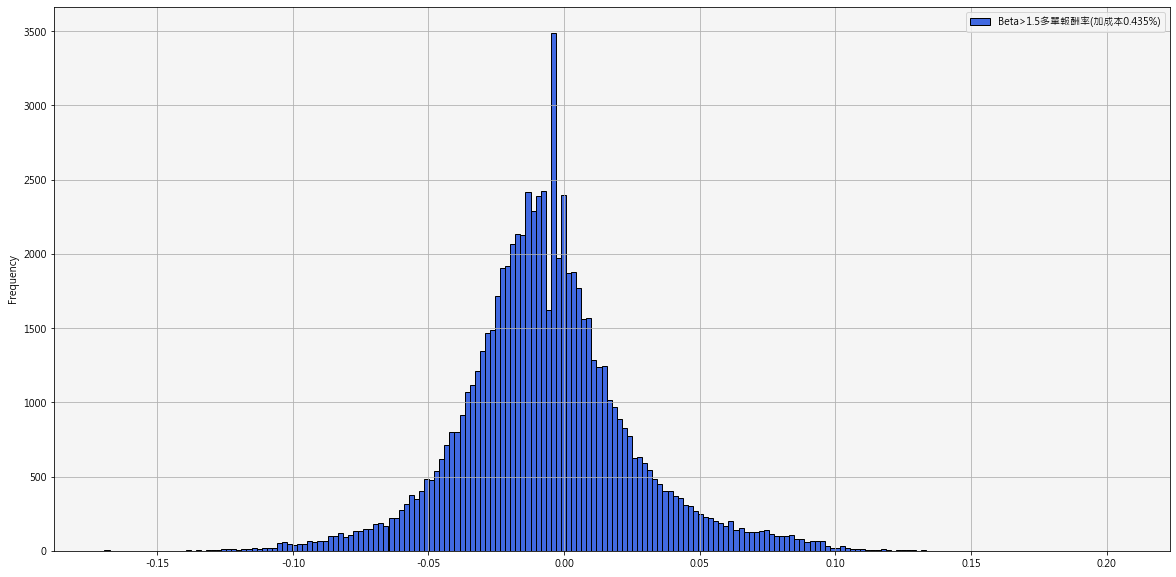

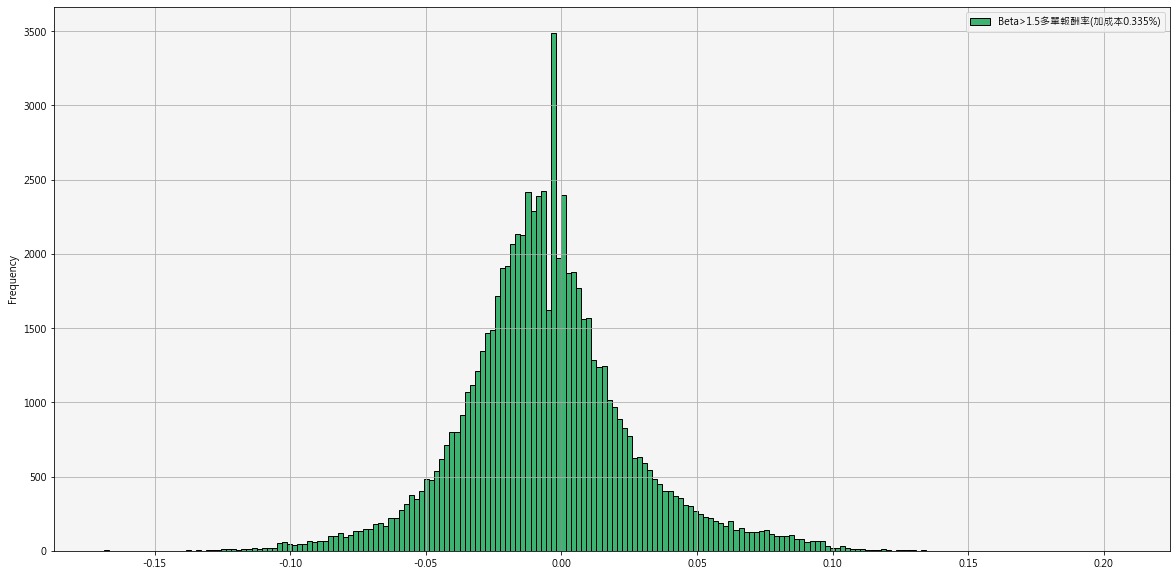

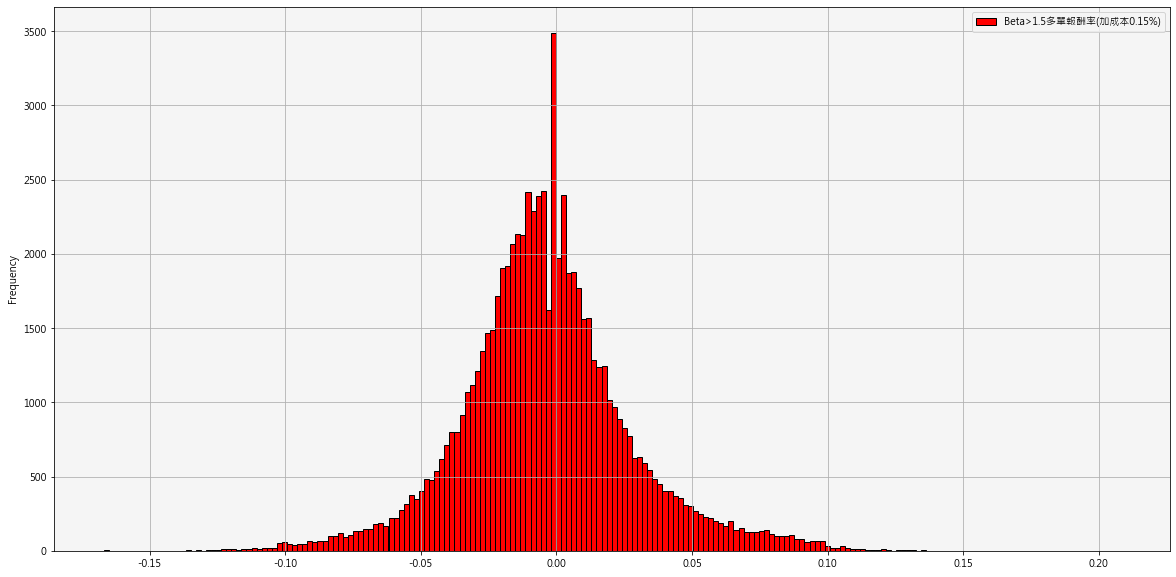

In [33]:
############################################################################################
#每日每股損益分配
#Beta大於1.5
############################################################################################
df_vol.set_index('日期')[['Beta>1.5多單報酬率(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
df_vol.set_index('日期')[['Beta>1.5多單報酬率(加成本0.335%)']].plot.hist(edgecolor='black',facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
df_vol.set_index('日期')[['Beta>1.5多單報酬率(加成本0.15%)']].plot.hist(edgecolor='black',facecolor = 'red',figsize = (20,10),bins=200,grid = True)

In [34]:
df_vol.set_index('日期')[['Beta>1.5多單報酬率(加成本0.435%)','Beta>1.5多單報酬率(加成本0.335%)','Beta>1.5多單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,Beta>1.5多單報酬率(加成本0.435%),Beta>1.5多單報酬率(加成本0.335%),Beta>1.5多單報酬率(加成本0.15%)
mean,-0.006897,-0.005897,-0.004047
std,0.031190,0.031190,0.031190
min,-0.169471,-0.168471,-0.166621
25%,-0.024276,-0.023276,-0.021426
50%,-0.008081,-0.007081,-0.005231
75%,0.008714,0.009714,0.011564
max,0.204559,0.205559,0.207409


<AxesSubplot: ylabel='Frequency'>

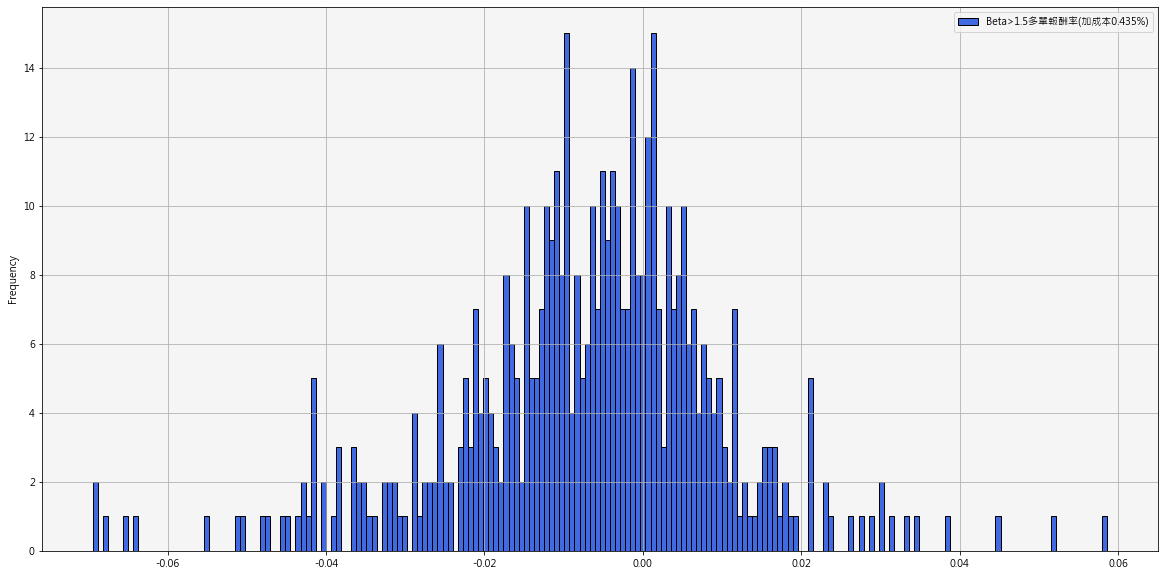

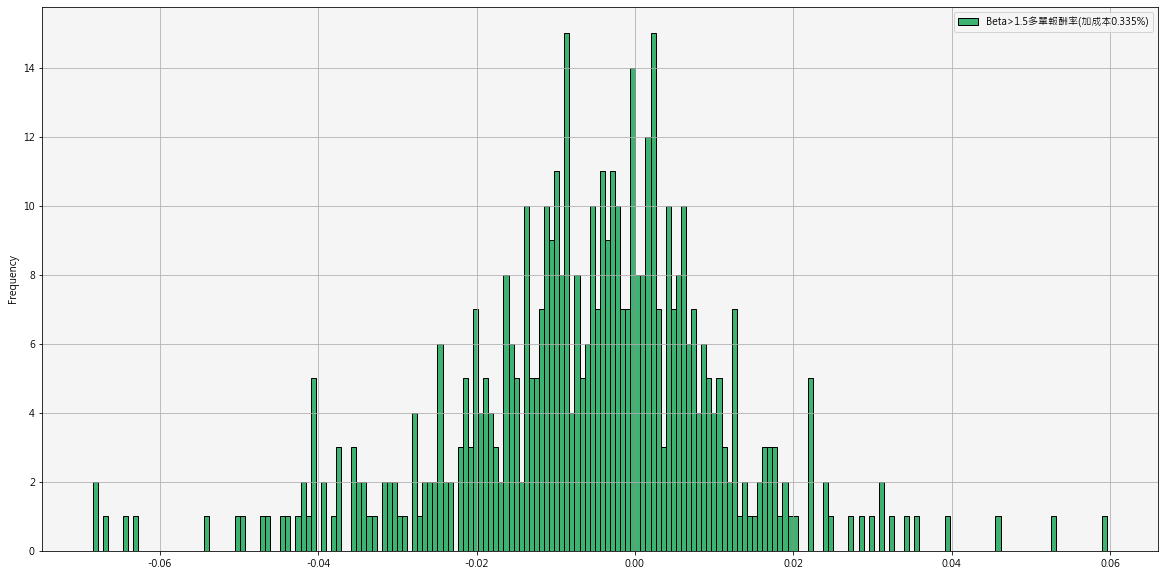

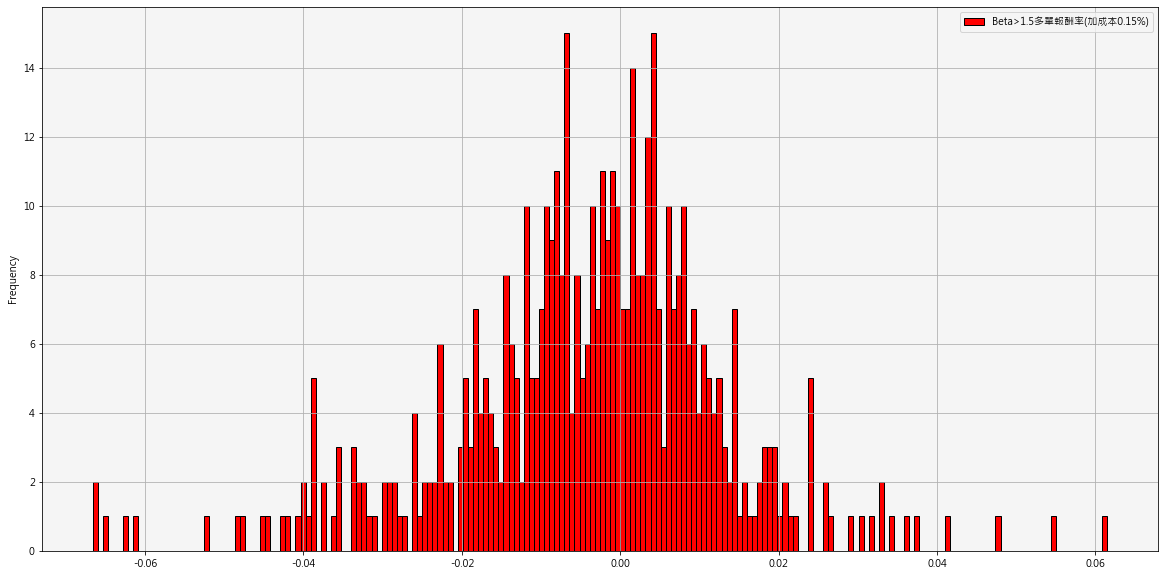

In [35]:
############################################################################################
#每日平均損益分配
#Beta大於1.5
############################################################################################
df_vol_day[['Beta>1.5多單報酬率(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=200,grid = True)
df_vol_day[['Beta>1.5多單報酬率(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=200,grid = True)
df_vol_day[['Beta>1.5多單報酬率(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=200,grid = True)

In [36]:
df_vol_day[['Beta>1.5多單報酬率(加成本0.435%)','Beta>1.5多單報酬率(加成本0.335%)','Beta>1.5多單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,Beta>1.5多單報酬率(加成本0.435%),Beta>1.5多單報酬率(加成本0.335%),Beta>1.5多單報酬率(加成本0.15%)
mean,-0.007000,-0.006000,-0.004150
std,0.017003,0.017003,0.017003
min,-0.069479,-0.068479,-0.066629
25%,-0.015022,-0.014022,-0.012172
50%,-0.005283,-0.004283,-0.002433
75%,0.002984,0.003984,0.005834
max,0.058616,0.059616,0.061466


<AxesSubplot: xlabel='日期'>

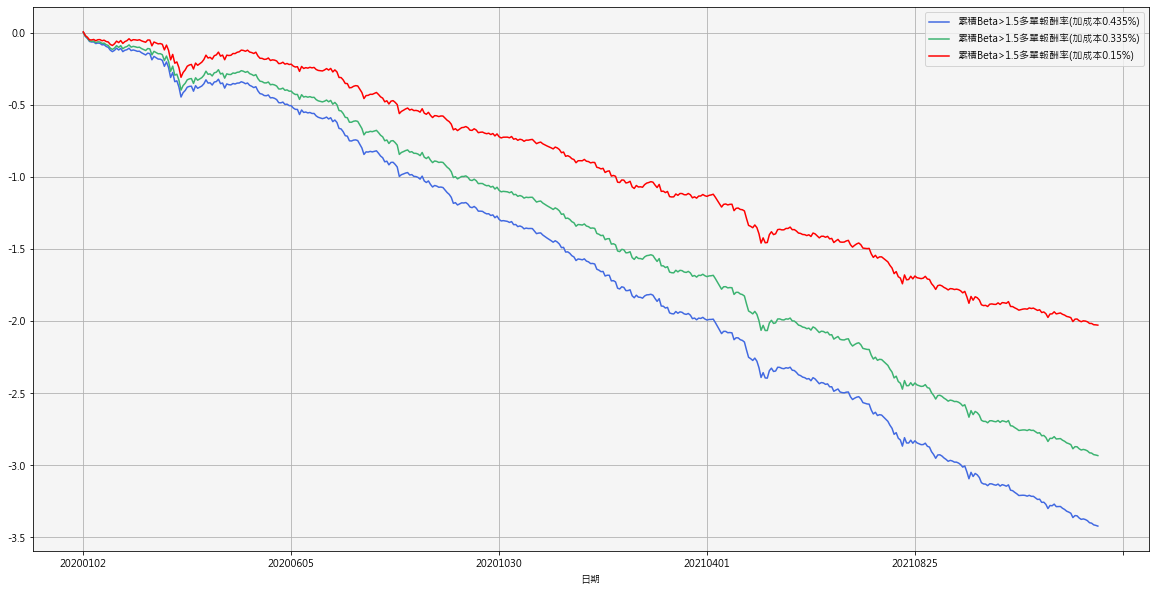

In [37]:
df_vol_day[['累積Beta>1.5多單報酬率(加成本0.435%)','累積Beta>1.5多單報酬率(加成本0.335%)','累積Beta>1.5多單報酬率(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=4>開盤賣出收盤回補，做空單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

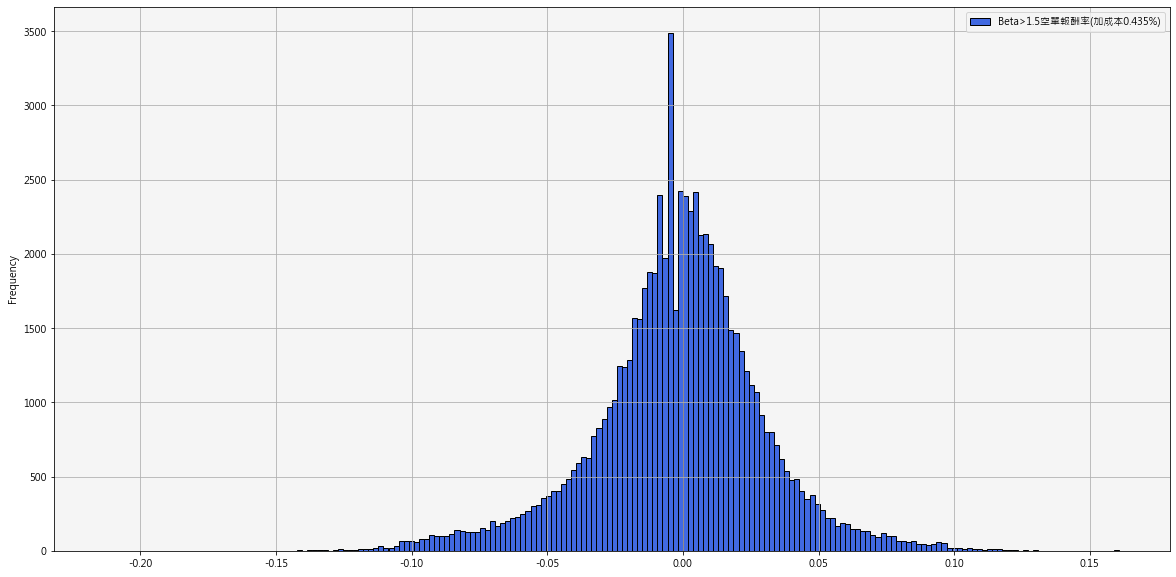

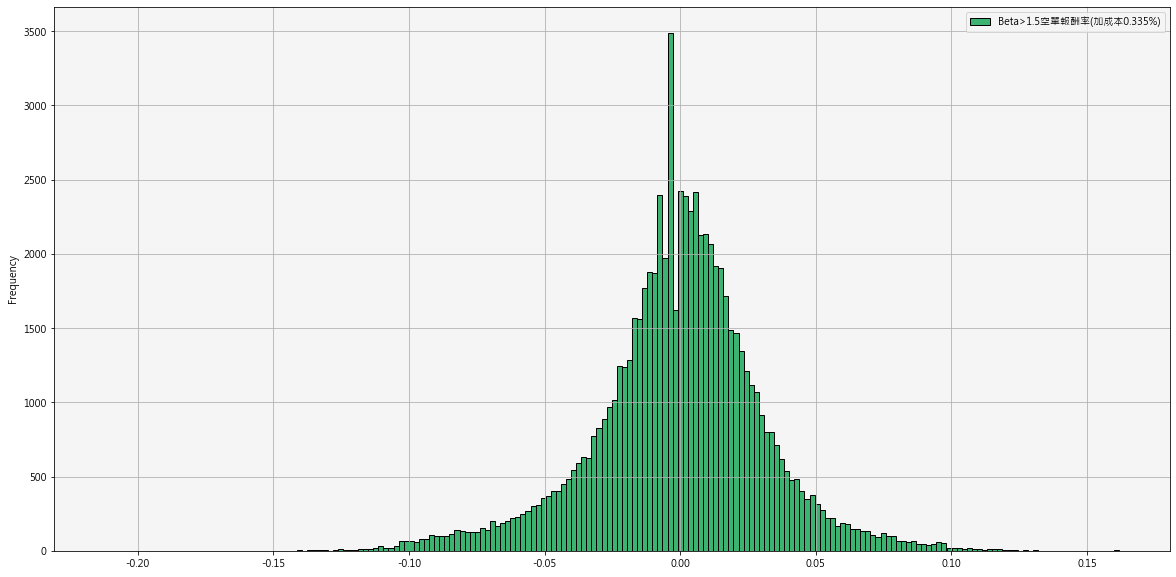

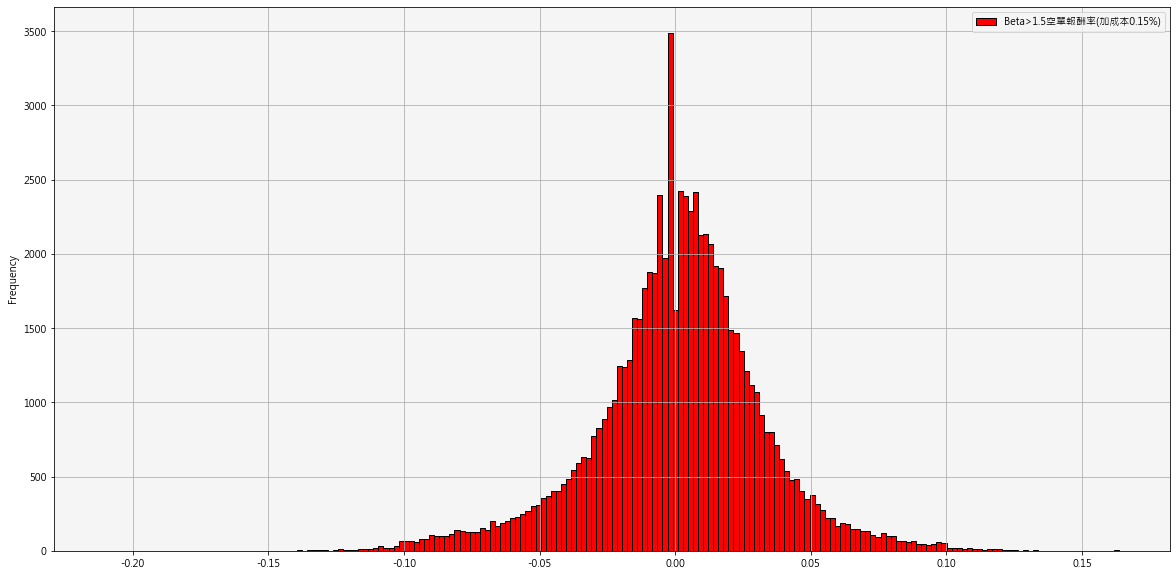

In [38]:
############################################################################################
#每日每股損益分配
#Beta大於1.5
############################################################################################
df_vol.set_index('日期')[['Beta>1.5空單報酬率(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
df_vol.set_index('日期')[['Beta>1.5空單報酬率(加成本0.335%)']].plot.hist(edgecolor='black',facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
df_vol.set_index('日期')[['Beta>1.5空單報酬率(加成本0.15%)']].plot.hist(edgecolor='black',facecolor = 'red',figsize = (20,10),bins=200,grid = True)

In [39]:
df_vol.set_index('日期')[['Beta>1.5空單報酬率(加成本0.435%)','Beta>1.5空單報酬率(加成本0.335%)','Beta>1.5空單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,Beta>1.5空單報酬率(加成本0.435%),Beta>1.5空單報酬率(加成本0.335%),Beta>1.5空單報酬率(加成本0.15%)
mean,-0.001803,-0.000803,0.001047
std,0.031190,0.031190,0.031190
min,-0.213259,-0.212259,-0.210409
25%,-0.017414,-0.016414,-0.014564
50%,-0.000619,0.000381,0.002231
75%,0.015576,0.016576,0.018426
max,0.160771,0.161771,0.163621


<AxesSubplot: ylabel='Frequency'>

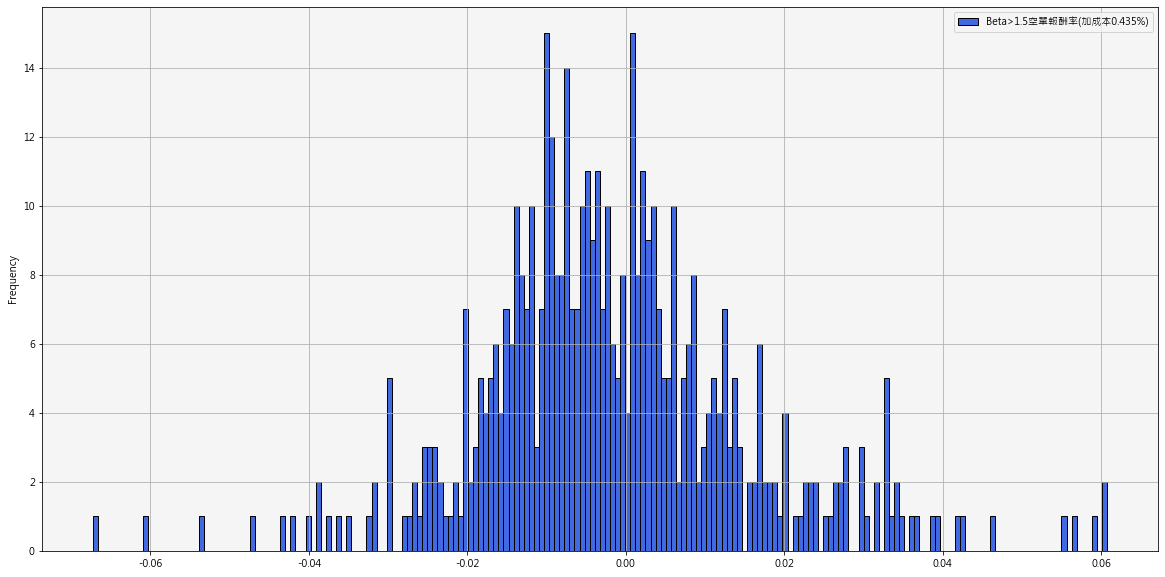

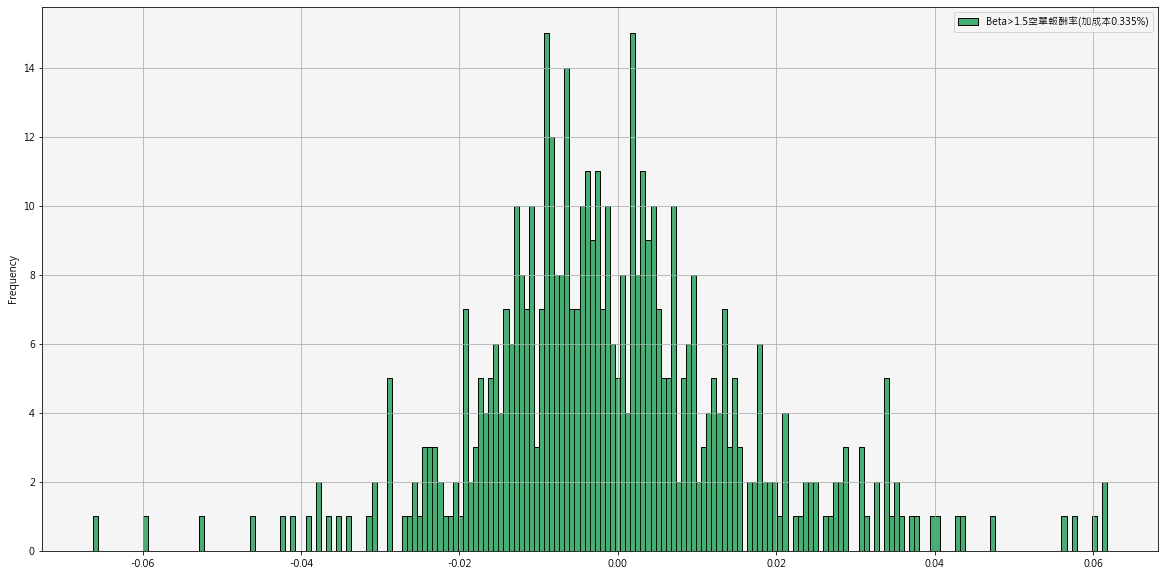

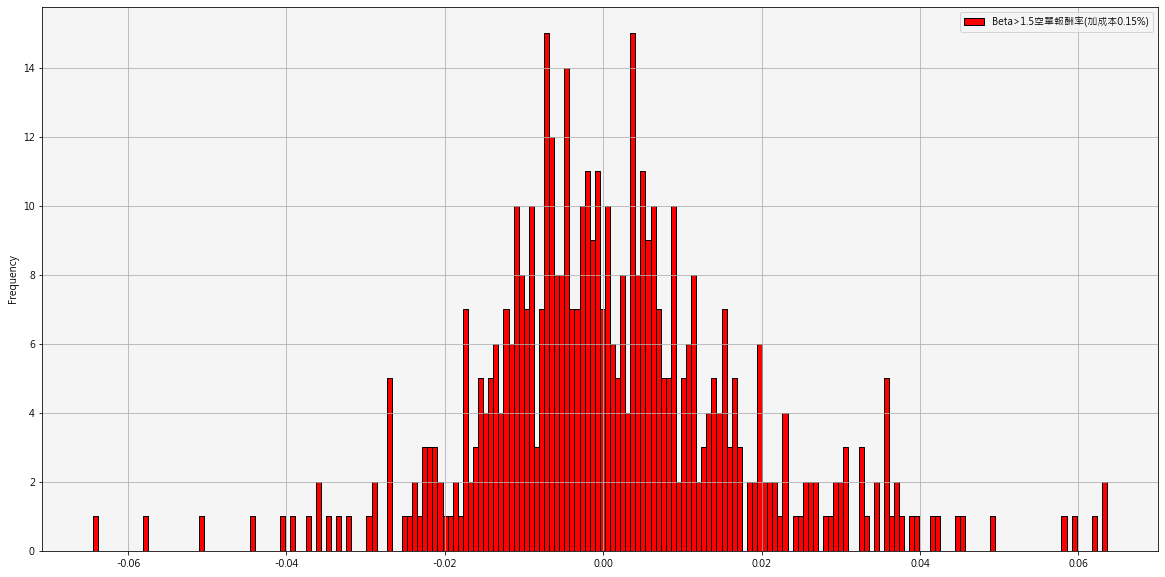

In [40]:
############################################################################################
#每日平均損益分配
#Beta大於1.5
############################################################################################
df_vol_day[['Beta>1.5空單報酬率(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=200,grid = True)
df_vol_day[['Beta>1.5空單報酬率(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=200,grid = True)
df_vol_day[['Beta>1.5空單報酬率(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=200,grid = True)

In [41]:
df_vol_day[['Beta>1.5空單報酬率(加成本0.435%)','Beta>1.5空單報酬率(加成本0.335%)','Beta>1.5空單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,Beta>1.5空單報酬率(加成本0.435%),Beta>1.5空單報酬率(加成本0.335%),Beta>1.5空單報酬率(加成本0.15%)
mean,-0.001700,-0.000700,0.001150
std,0.017003,0.017003,0.017003
min,-0.067316,-0.066316,-0.064466
25%,-0.011684,-0.010684,-0.008834
50%,-0.003417,-0.002417,-0.000567
75%,0.006322,0.007322,0.009172
max,0.060779,0.061779,0.063629


<AxesSubplot: xlabel='日期'>

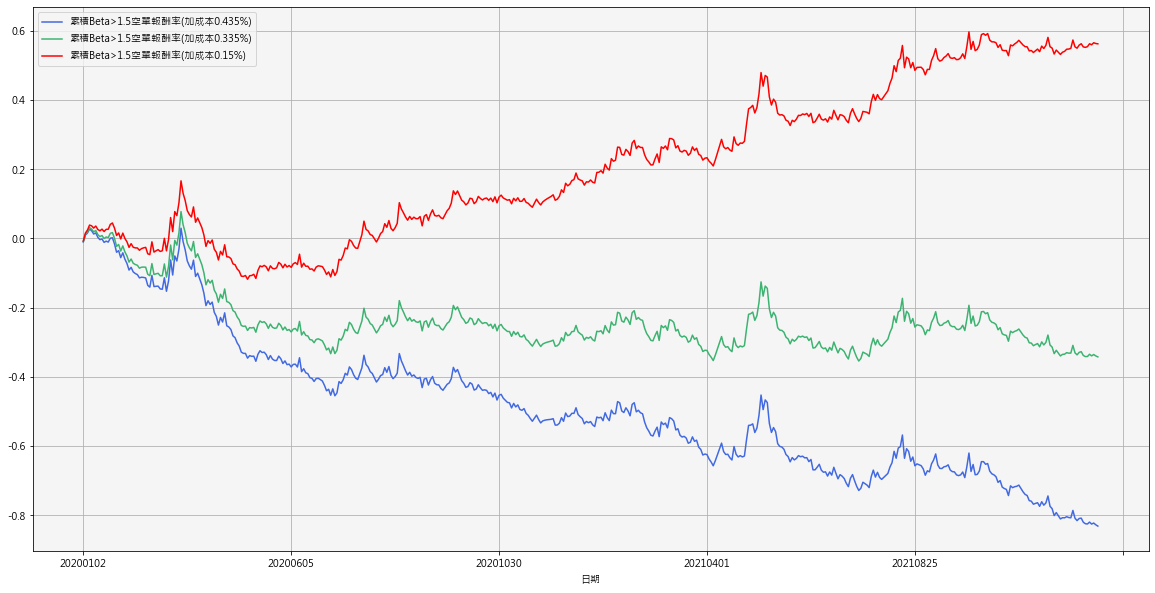

In [42]:
df_vol_day[['累積Beta>1.5空單報酬率(加成本0.435%)','累積Beta>1.5空單報酬率(加成本0.335%)','累積Beta>1.5空單報酬率(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=5>選股後模型損益</font>**

**<font  size=4>每日檔數</font>**

In [43]:
############################################################################################
#做多
############################################################################################
pool_long.groupby('日期').count()[['股票代號']].T

日期,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,20200116,20200117,20200120,20200130,20200131,20200203,20200204,20200205,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,20200220,20200221,20200224,20200225,20200226,20200227,20200302,20200303,20200304,20200305,20200306,20200309,20200310,20200311,20200312,20200313,20200316,20200317,20200318,20200319,20200320,20200323,20200324,20200325,20200326,20200327,20200330,20200331,20200401,20200406,20200407,20200408,20200409,20200410,20200413,20200414,20200415,20200416,20200417,20200420,20200421,20200422,20200423,20200424,20200427,20200428,20200429,20200430,...,20210914,20210915,20210916,20210917,20210922,20210923,20210924,20210927,20210928,20210929,20210930,20211001,20211004,20211005,20211006,20211007,20211008,20211012,20211013,20211014,20211015,20211018,20211019,20211020,20211021,20211022,20211025,20211026,20211027,20211028,20211029,20211101,20211102,20211103,20211104,20211105,20211108,20211109,20211110,20211111,20211112,20211115,20211116,20211117,20211118,20211119,20211122,20211123,20211124,20211125,20211126,20211129,20211130,20211201,20211202,20211203,20211206,20211207,20211208,20211209,20211210,20211213,20211214,20211215,20211216,20211217,20211220,20211221,20211222,20211223,20211224,20211227,20211228,20211229,20211230
股票代號,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [44]:
############################################################################################
#做空
############################################################################################
pool_short.groupby('日期').count()[['股票代號']].T


日期,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,20200116,20200117,20200120,20200130,20200131,20200203,20200204,20200205,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,20200220,20200221,20200224,20200225,20200226,20200227,20200302,20200303,20200304,20200305,20200306,20200309,20200310,20200311,20200312,20200313,20200316,20200317,20200318,20200319,20200320,20200323,20200324,20200325,20200326,20200327,20200330,20200331,20200401,20200406,20200407,20200408,20200409,20200410,20200413,20200414,20200415,20200416,20200417,20200420,20200421,20200422,20200423,20200424,20200427,20200428,20200429,20200430,...,20210914,20210915,20210916,20210917,20210922,20210923,20210924,20210927,20210928,20210929,20210930,20211001,20211004,20211005,20211006,20211007,20211008,20211012,20211013,20211014,20211015,20211018,20211019,20211020,20211021,20211022,20211025,20211026,20211027,20211028,20211029,20211101,20211102,20211103,20211104,20211105,20211108,20211109,20211110,20211111,20211112,20211115,20211116,20211117,20211118,20211119,20211122,20211123,20211124,20211125,20211126,20211129,20211130,20211201,20211202,20211203,20211206,20211207,20211208,20211209,20211210,20211213,20211214,20211215,20211216,20211217,20211220,20211221,20211222,20211223,20211224,20211227,20211228,20211229,20211230
股票代號,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


**<font  size=4>開盤進收盤出，做多單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

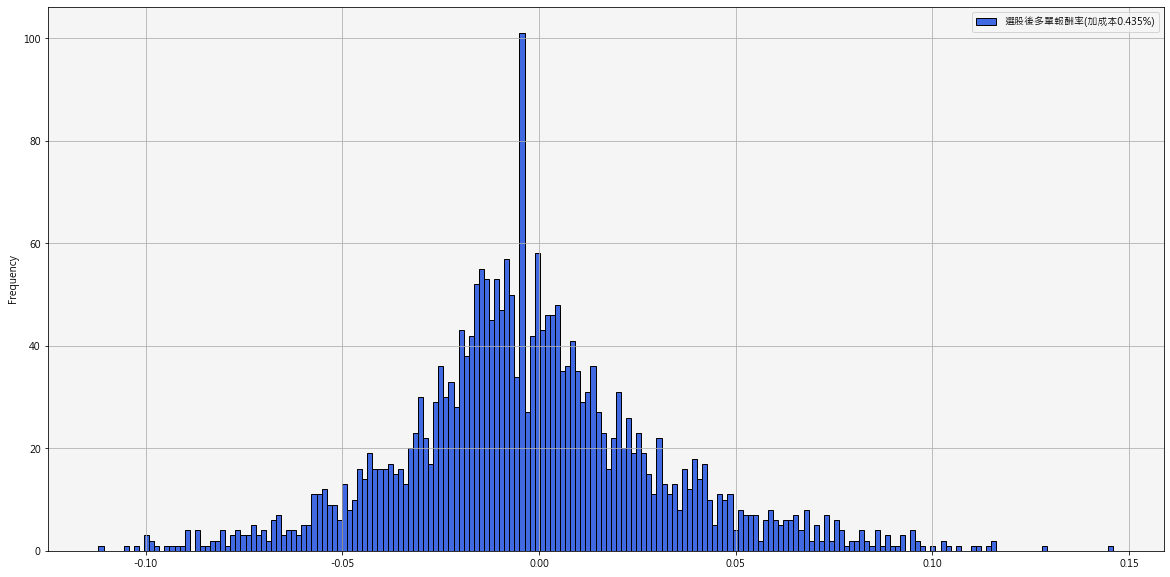

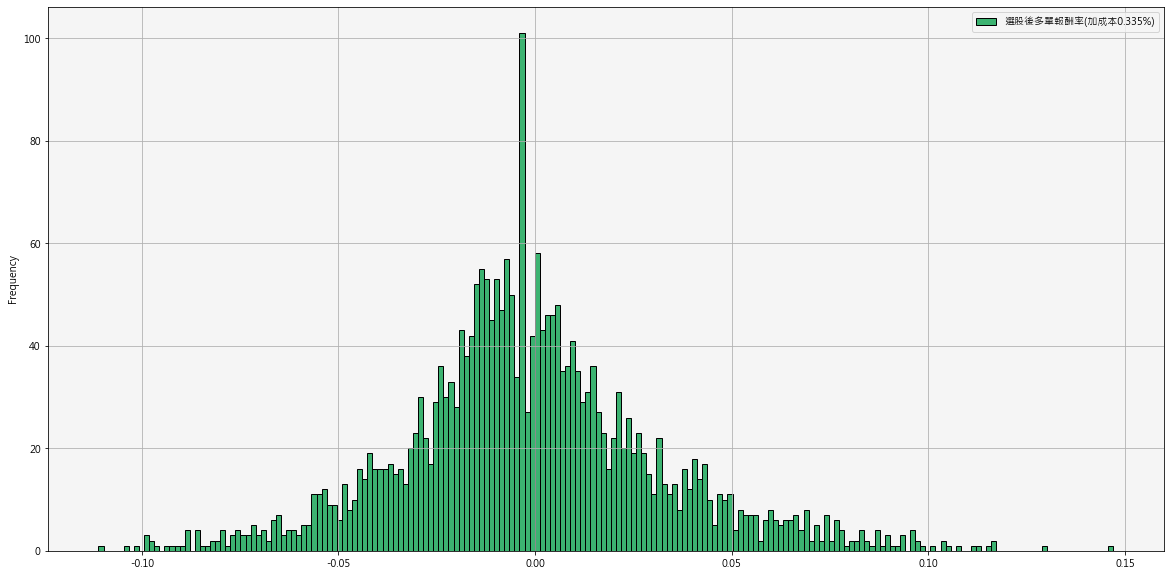

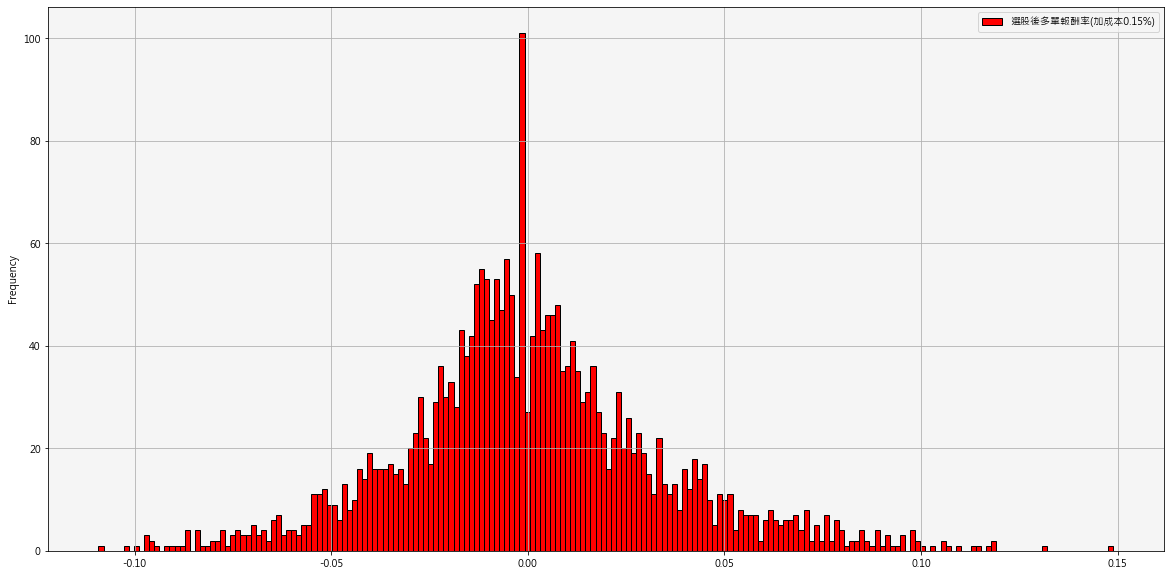

In [45]:
############################################################################################
#每日每股損益分配
#選股後
############################################################################################
pool_long.set_index('日期')[['選股後多單報酬率(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
pool_long.set_index('日期')[['選股後多單報酬率(加成本0.335%)']].plot.hist(edgecolor='black',facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
pool_long.set_index('日期')[['選股後多單報酬率(加成本0.15%)']].plot.hist(edgecolor='black',facecolor = 'red',figsize = (20,10),bins=200,grid = True)

In [46]:
pool_long.set_index('日期')[['選股後多單報酬率(加成本0.435%)','選股後多單報酬率(加成本0.335%)','選股後多單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,選股後多單報酬率(加成本0.435%),選股後多單報酬率(加成本0.335%),選股後多單報酬率(加成本0.15%)
mean,-0.002377,-0.001377,0.000473
std,0.032956,0.032956,0.032956
min,-0.112042,-0.111042,-0.109192
25%,-0.020505,-0.019505,-0.017655
50%,-0.004350,-0.003350,-0.001500
75%,0.014264,0.015264,0.017114
max,0.145957,0.146957,0.148807


<AxesSubplot: ylabel='Frequency'>

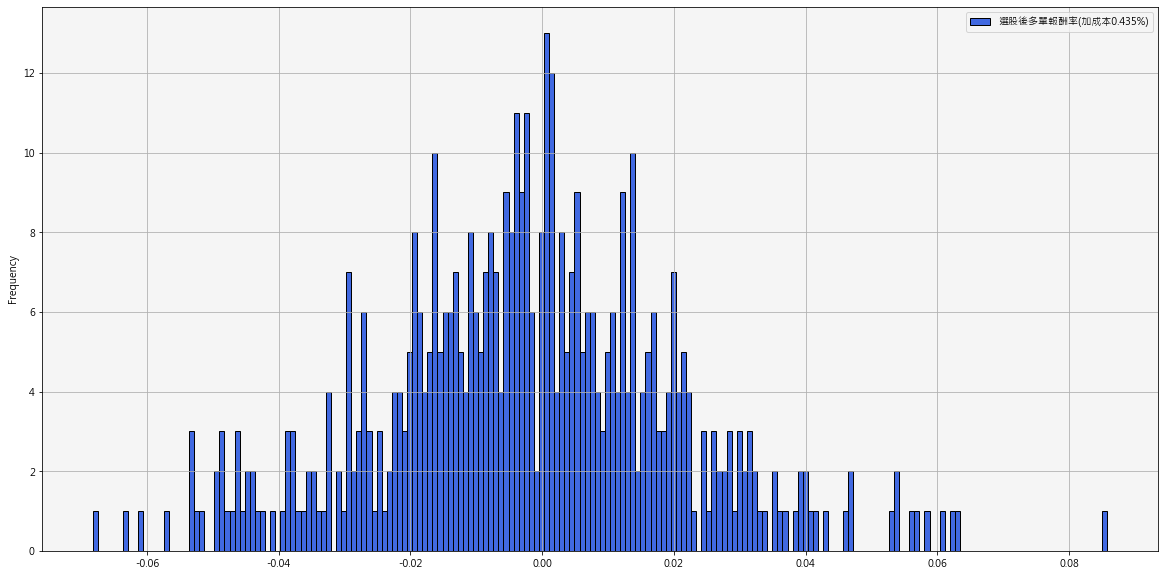

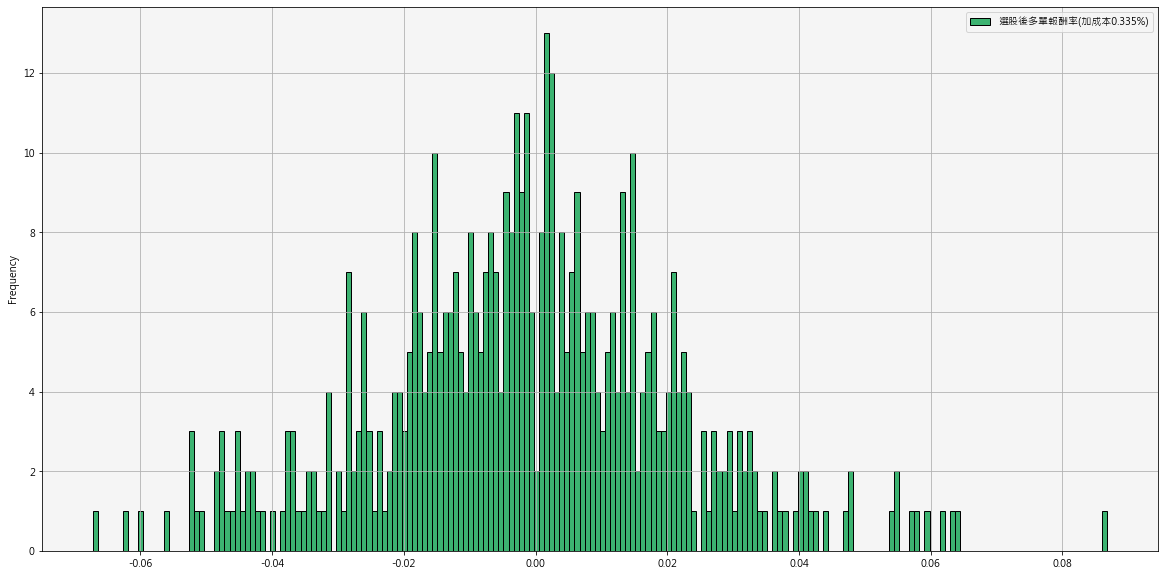

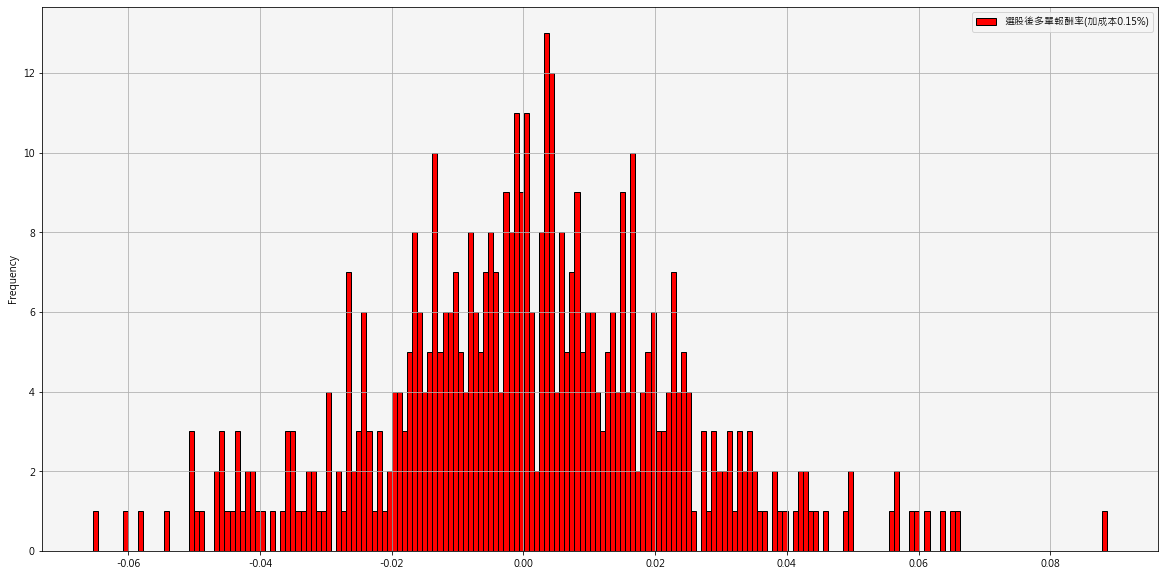

In [47]:
############################################################################################
#每日平均損益分配
#選股後
############################################################################################
pool_long_day[['選股後多單報酬率(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=200,grid = True)
pool_long_day[['選股後多單報酬率(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=200,grid = True)
pool_long_day[['選股後多單報酬率(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=200,grid = True)

In [48]:
pool_long_day[['選股後多單報酬率(加成本0.435%)','選股後多單報酬率(加成本0.335%)','選股後多單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,選股後多單報酬率(加成本0.435%),選股後多單報酬率(加成本0.335%),選股後多單報酬率(加成本0.15%)
mean,-0.002377,-0.001377,0.000473
std,0.022679,0.022679,0.022679
min,-0.068269,-0.067269,-0.065419
25%,-0.016142,-0.015142,-0.013292
50%,-0.002673,-0.001673,0.000177
75%,0.012034,0.013034,0.014884
max,0.085787,0.086787,0.088637


<AxesSubplot: xlabel='日期'>

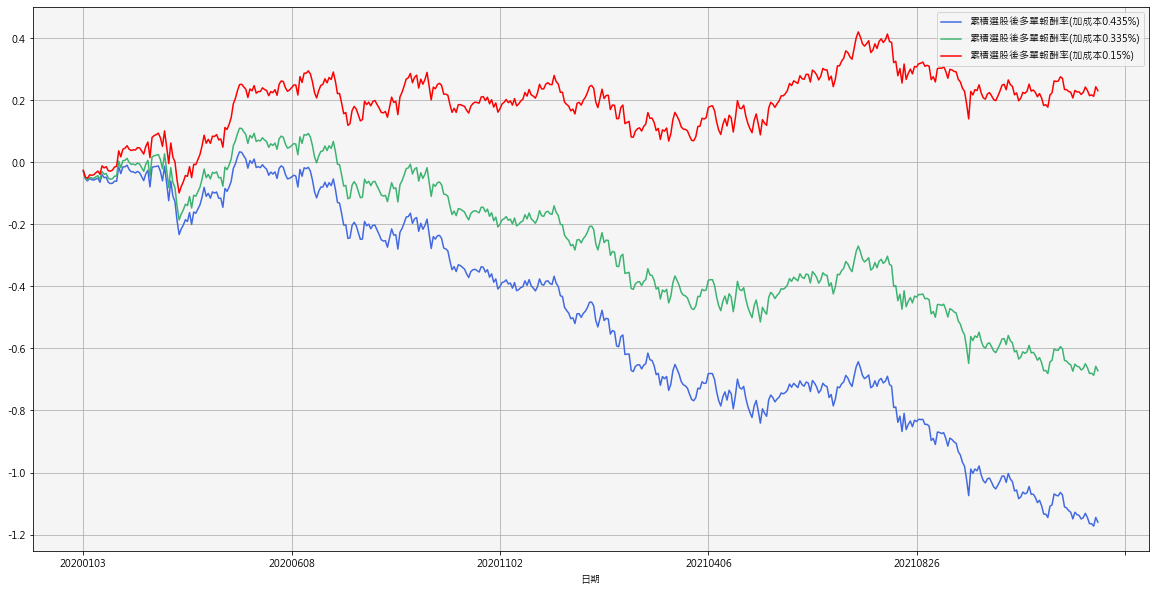

In [49]:
pool_long_day[['累積選股後多單報酬率(加成本0.435%)','累積選股後多單報酬率(加成本0.335%)','累積選股後多單報酬率(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=4>開盤賣出收盤回補，做空單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

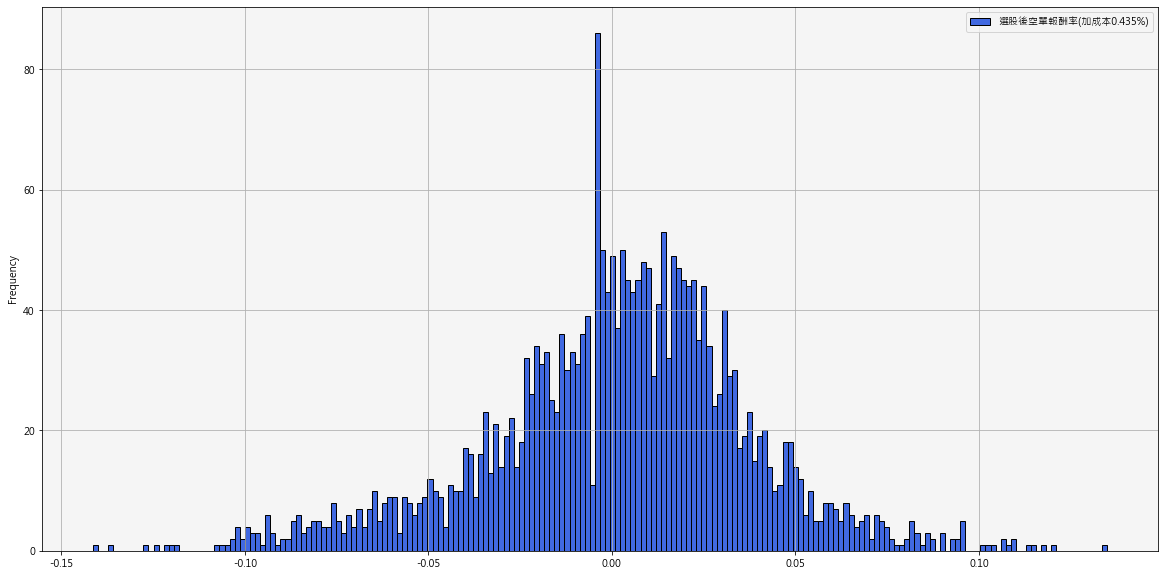

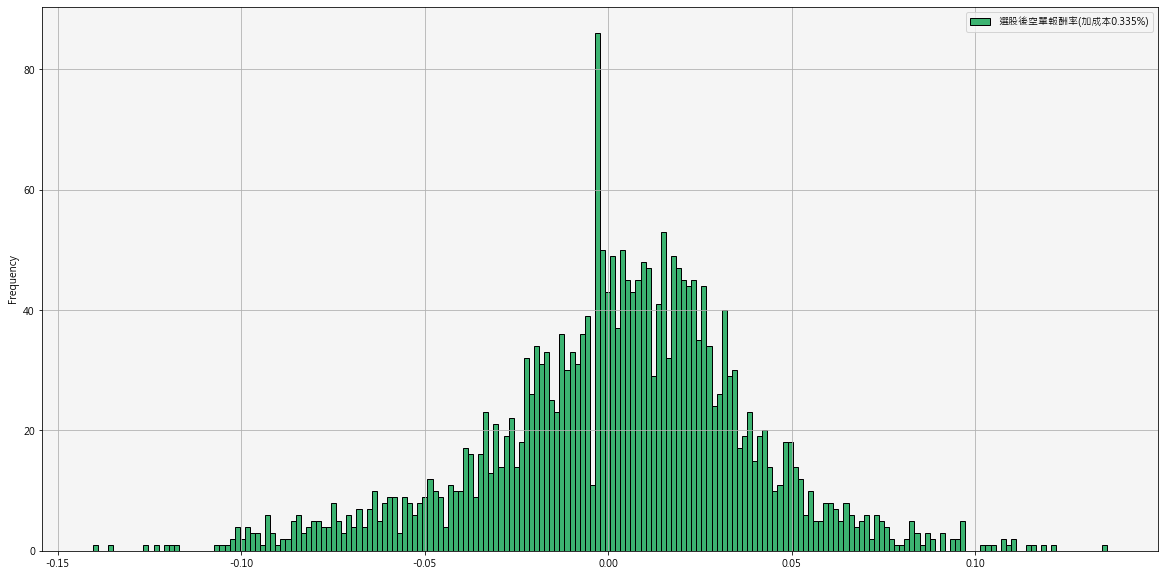

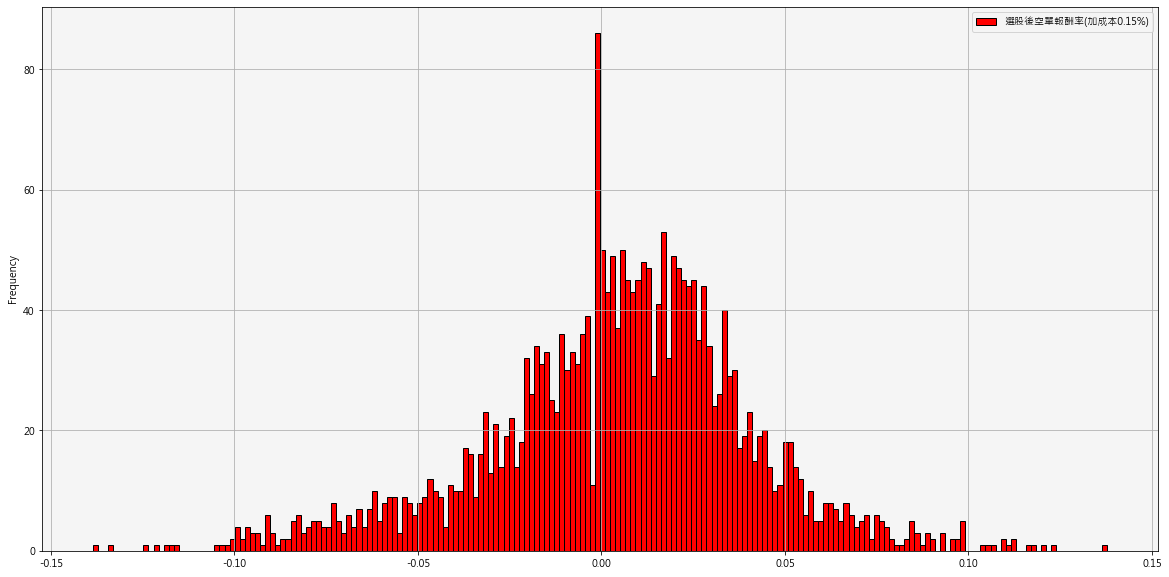

In [50]:
############################################################################################
#每日每股損益分配
#選股後
############################################################################################
pool_short.set_index('日期')[['選股後空單報酬率(加成本0.435%)']].plot.hist(edgecolor='black', facecolor = 'royalblue',figsize = (20,10),bins=200,grid = True)
pool_short.set_index('日期')[['選股後空單報酬率(加成本0.335%)']].plot.hist(edgecolor='black',facecolor = 'mediumseagreen',figsize = (20,10),bins=200,grid = True)
pool_short.set_index('日期')[['選股後空單報酬率(加成本0.15%)']].plot.hist(edgecolor='black',facecolor = 'red',figsize = (20,10),bins=200,grid = True)

In [51]:
pool_short.set_index('日期')[['選股後空單報酬率(加成本0.435%)','選股後空單報酬率(加成本0.335%)','選股後空單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,選股後空單報酬率(加成本0.435%),選股後空單報酬率(加成本0.335%),選股後空單報酬率(加成本0.15%)
mean,0.001551,0.002551,0.004401
std,0.036074,0.036074,0.036074
min,-0.141447,-0.140447,-0.138597
25%,-0.018035,-0.017035,-0.015185
50%,0.004135,0.005135,0.006985
75%,0.023237,0.024237,0.026087
max,0.134948,0.135948,0.137798


<AxesSubplot: ylabel='Frequency'>

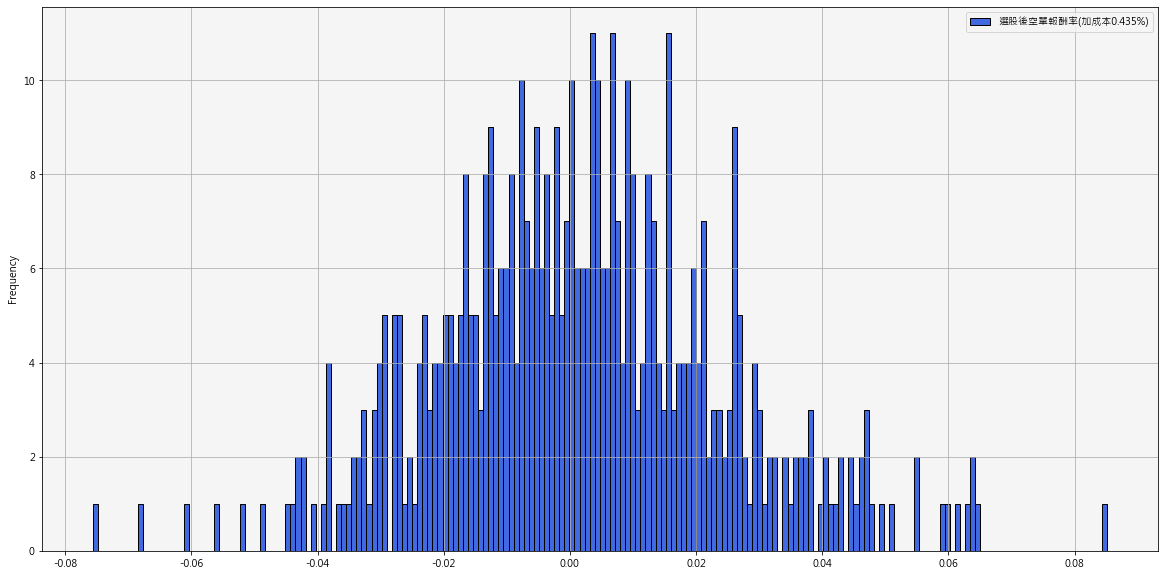

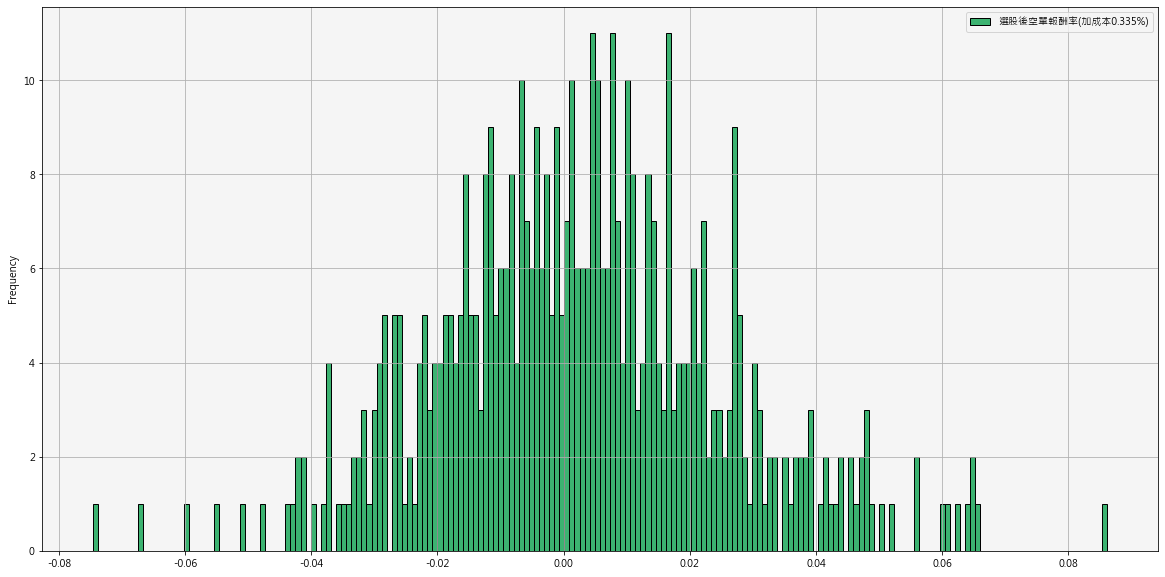

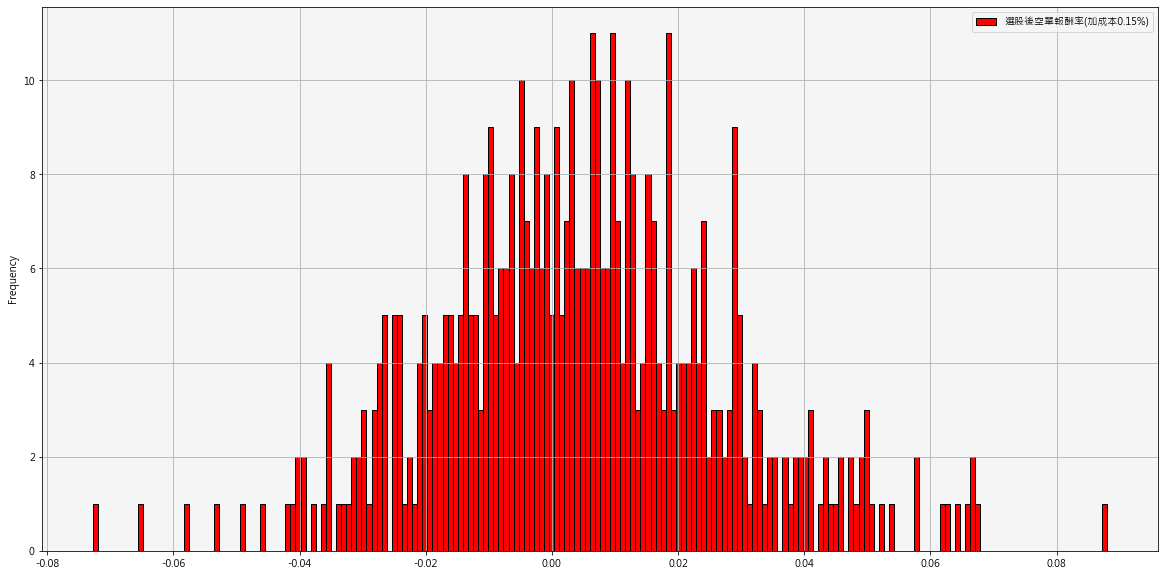

In [52]:
############################################################################################
#每日平均損益分配
#選股後
############################################################################################
pool_short_day[['選股後空單報酬率(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=200,grid = True)
pool_short_day[['選股後空單報酬率(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=200,grid = True)
pool_short_day[['選股後空單報酬率(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=200,grid = True)

In [53]:
pool_short_day[['選股後空單報酬率(加成本0.435%)','選股後空單報酬率(加成本0.335%)','選股後空單報酬率(加成本0.15%)']].describe().iloc[1:,:]

,選股後空單報酬率(加成本0.435%),選股後空單報酬率(加成本0.335%),選股後空單報酬率(加成本0.15%)
mean,0.001551,0.002551,0.004401
std,0.022658,0.022658,0.022658
min,-0.075671,-0.074671,-0.072821
25%,-0.013022,-0.012022,-0.010172
50%,0.001073,0.002073,0.003923
75%,0.015277,0.016277,0.018127
max,0.085166,0.086166,0.088016


<AxesSubplot: xlabel='日期'>

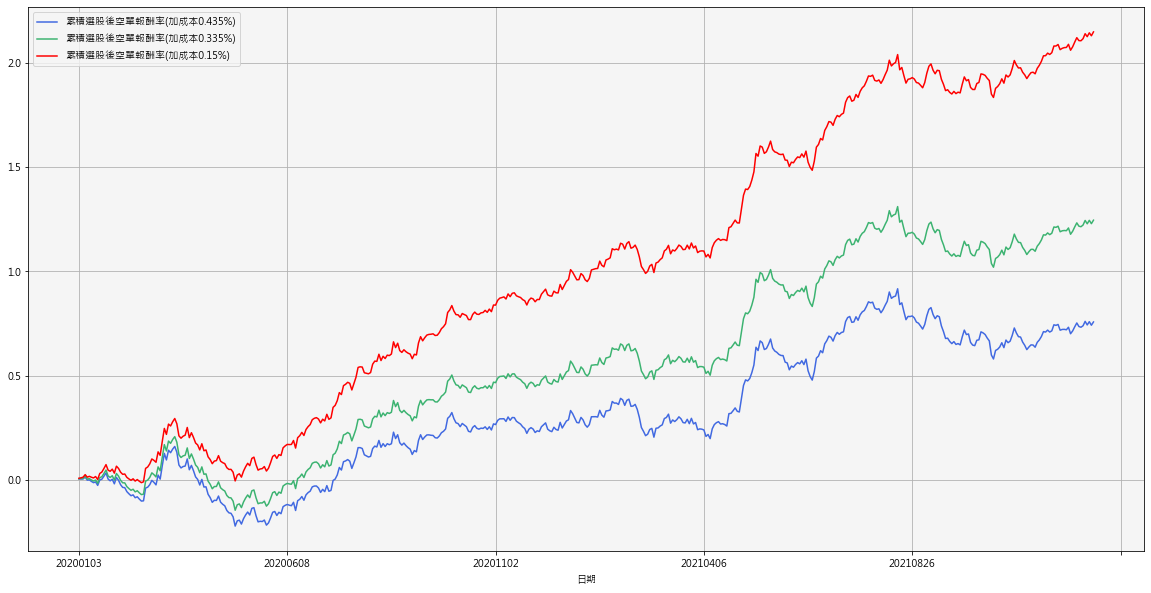

In [54]:
pool_short_day[['累積選股後空單報酬率(加成本0.435%)','累積選股後空單報酬率(加成本0.335%)','累積選股後空單報酬率(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=5>組合損益</font>**

**<font  size=4>VIX>=25，開盤進收盤出，做多單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

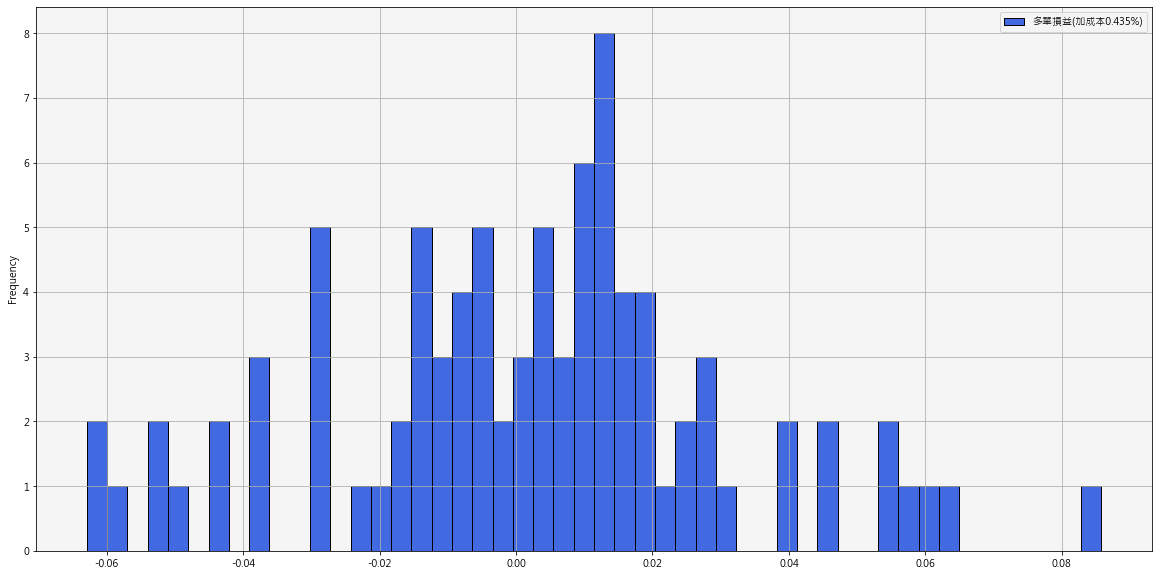

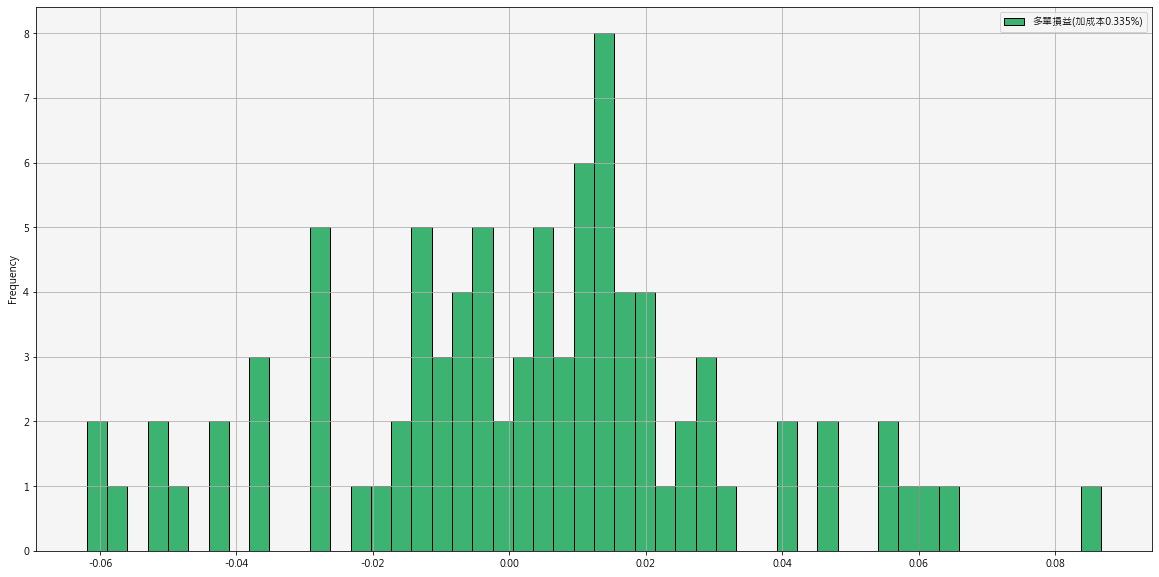

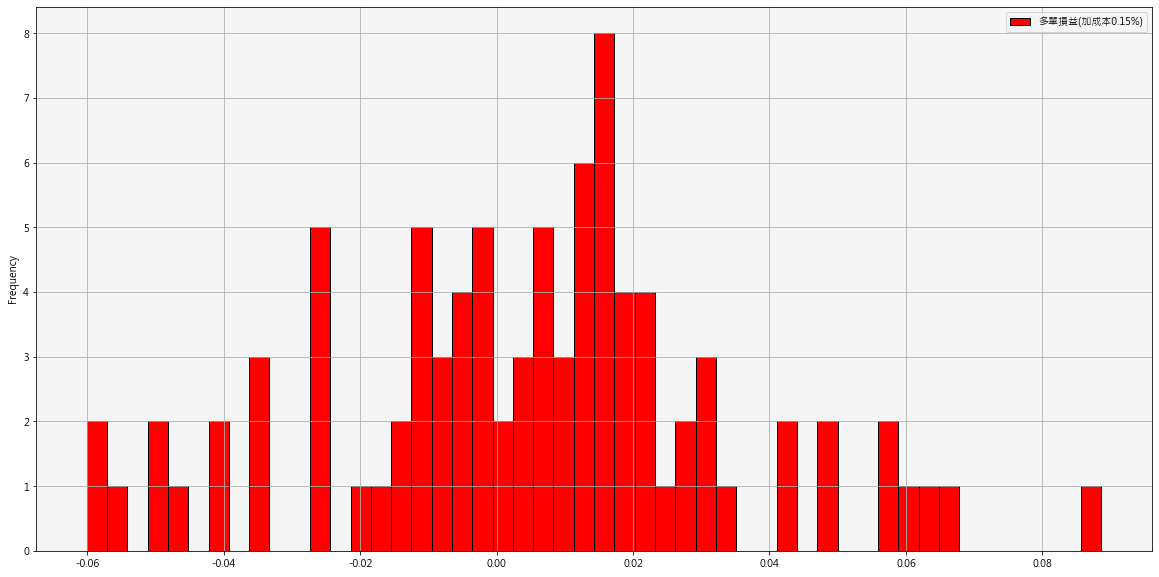

In [55]:
############################################################################################
#每日平均損益分配
#VIX>=25多單
############################################################################################
pool_combine[pool_combine['多單損益(加成本0.435%)']!=0][['多單損益(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=50,grid = True)
pool_combine[pool_combine['多單損益(加成本0.335%)']!=0][['多單損益(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=50,grid = True)
pool_combine[pool_combine['多單損益(加成本0.15%)']!=0][['多單損益(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=50,grid = True)

In [56]:
pool_combine[pool_combine['多單損益(加成本0.435%)']!=0][['多單損益(加成本0.435%)','多單損益(加成本0.335%)','多單損益(加成本0.15%)']].describe().iloc[1:,:]

,多單損益(加成本0.435%),多單損益(加成本0.335%),多單損益(加成本0.15%)
mean,0.001787,0.002787,0.004637
std,0.029358,0.029358,0.029358
min,-0.062908,-0.061908,-0.060058
25%,-0.013908,-0.012908,-0.011058
50%,0.003238,0.004238,0.006088
75%,0.016465,0.017465,0.019315
max,0.085787,0.086787,0.088637


<AxesSubplot: xlabel='日期'>

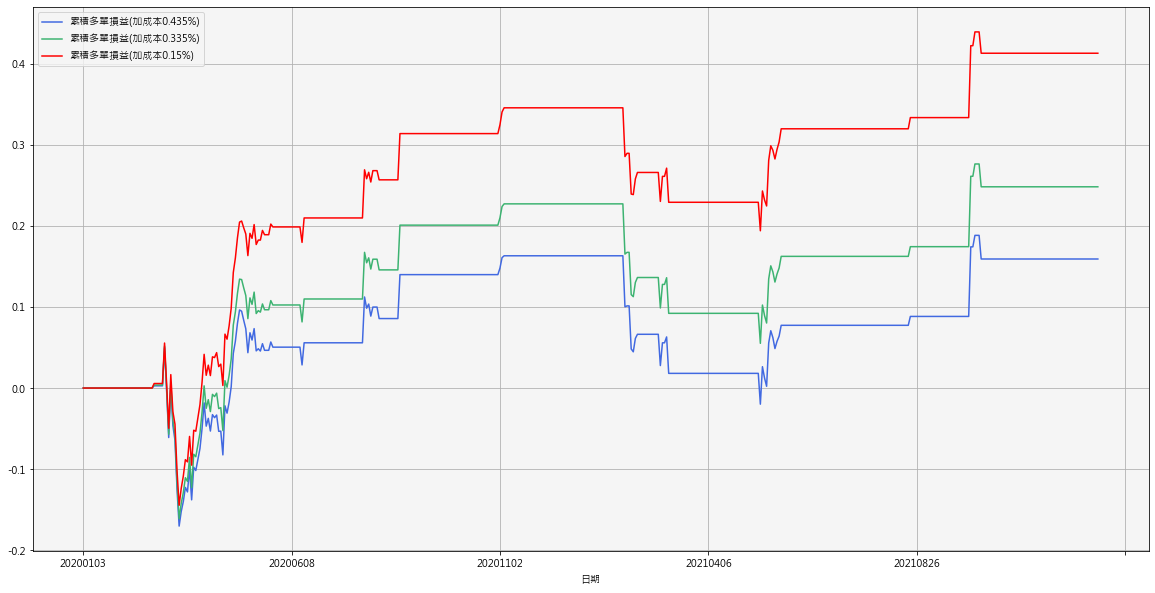

In [57]:
pool_combine[['累積多單損益(加成本0.435%)','累積多單損益(加成本0.335%)','累積多單損益(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=4>VIX<25，開盤賣空收盤回補，做空單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

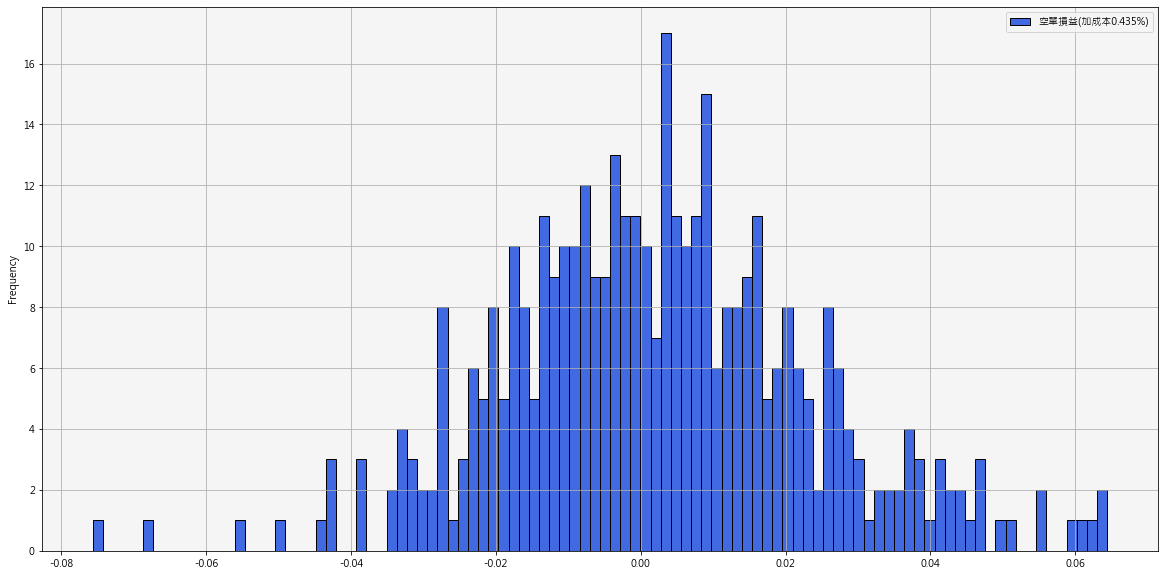

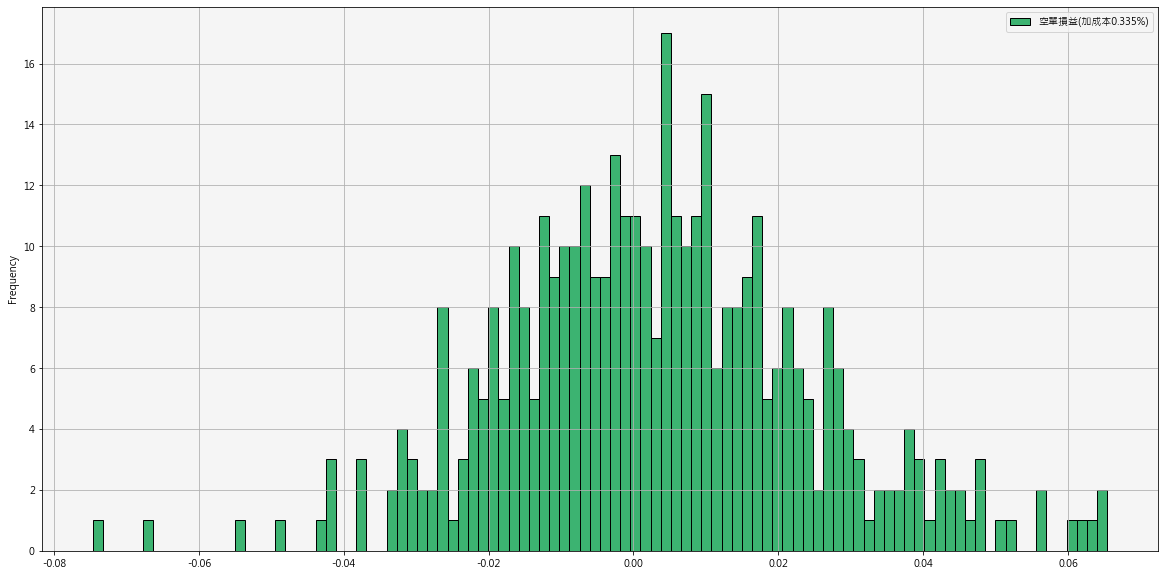

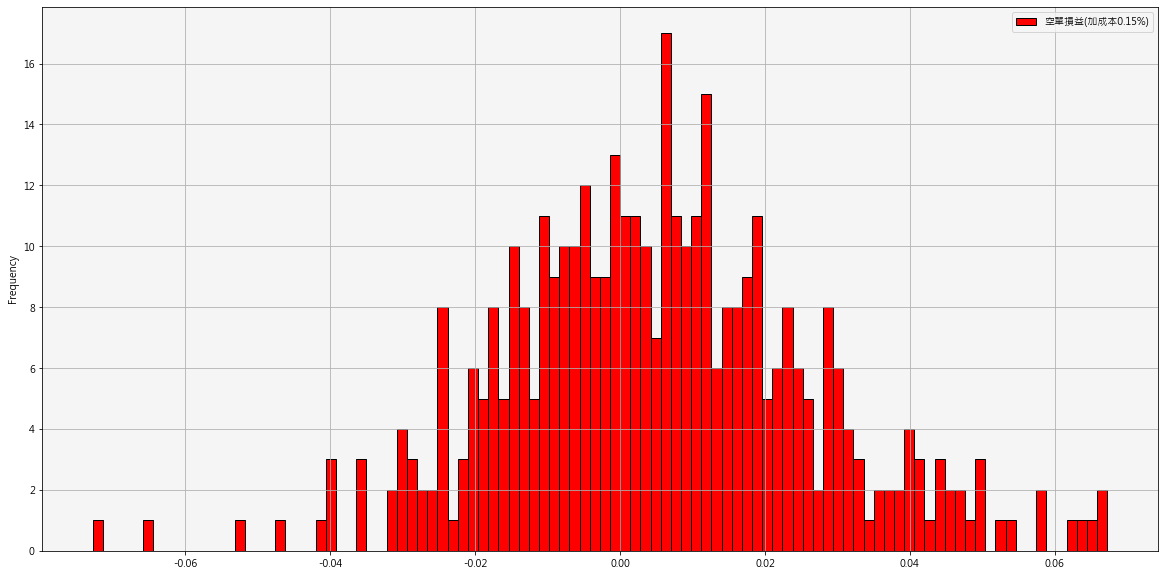

In [58]:
############################################################################################
#每日平均損益分配
#VIX<25，空單
############################################################################################
pool_combine[pool_combine['空單損益(加成本0.435%)']!=0][['空單損益(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=100,grid = True)
pool_combine[pool_combine['空單損益(加成本0.335%)']!=0][['空單損益(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=100,grid = True)
pool_combine[pool_combine['空單損益(加成本0.15%)']!=0][['空單損益(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=100,grid = True)

In [59]:
pool_combine[pool_combine['空單損益(加成本0.435%)']!=0][['空單損益(加成本0.435%)','空單損益(加成本0.335%)','空單損益(加成本0.15%)']].describe().iloc[1:,:]

,空單損益(加成本0.435%),空單損益(加成本0.335%),空單損益(加成本0.15%)
mean,0.002206,0.003206,0.005056
std,0.021416,0.021416,0.021416
min,-0.075671,-0.074671,-0.072821
25%,-0.011846,-0.010846,-0.008996
50%,0.001433,0.002433,0.004283
75%,0.015244,0.016244,0.018094
max,0.064381,0.065381,0.067231


<AxesSubplot: xlabel='日期'>

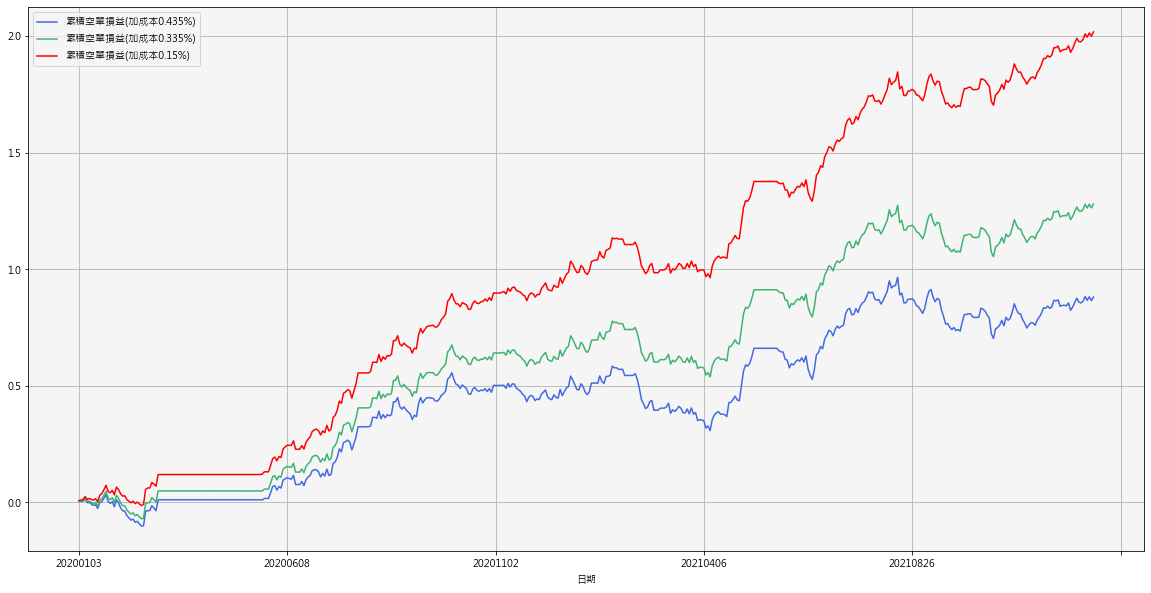

In [60]:
pool_combine[['累積空單損益(加成本0.435%)','累積空單損益(加成本0.335%)','累積空單損益(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)

**<font  size=4>VIX>=25，開盤進收盤出，做多單，VIX<25，開盤賣空收盤回補，做空單(加成本)</font>**

<AxesSubplot: ylabel='Frequency'>

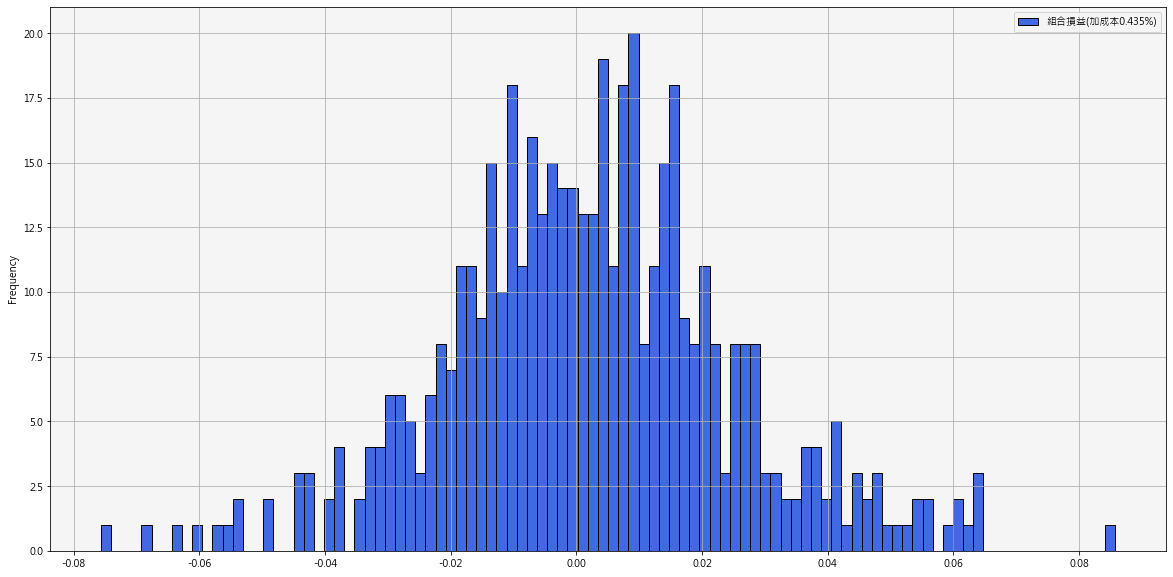

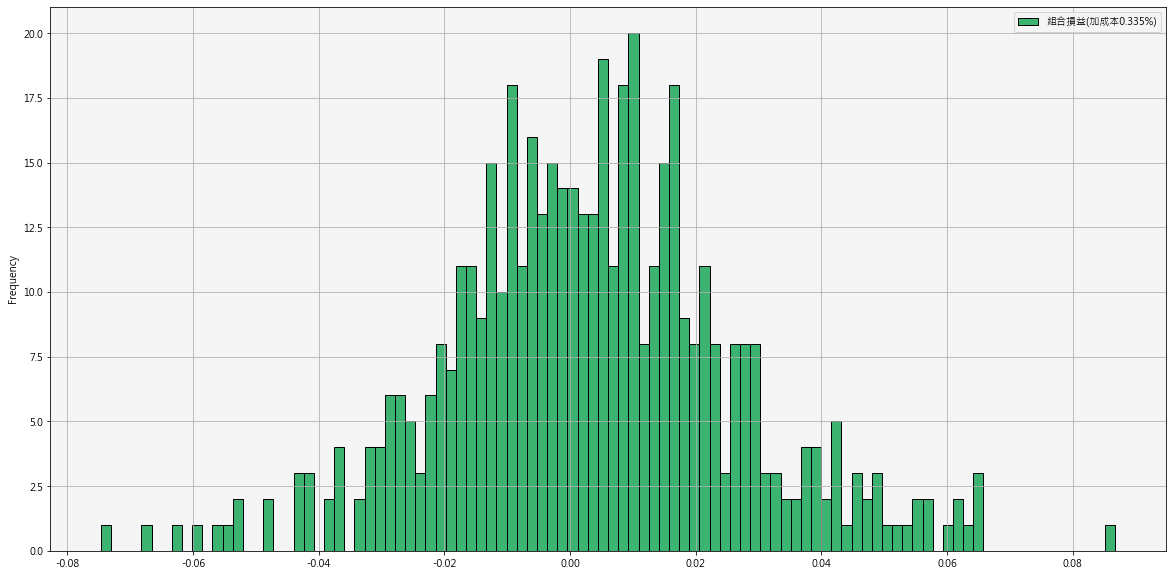

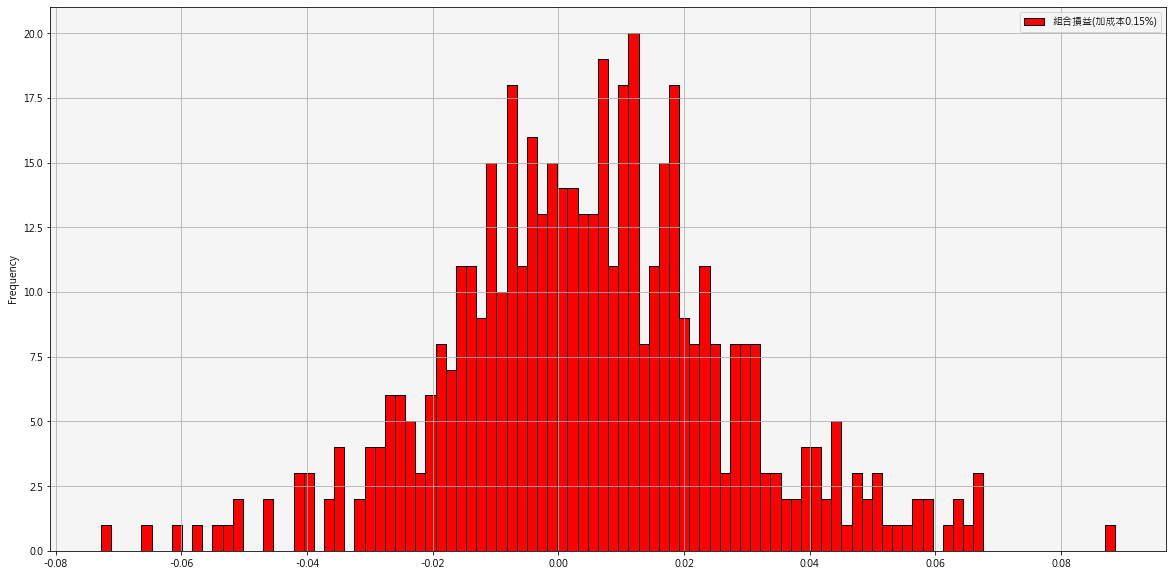

In [61]:
############################################################################################
#每日平均損益分配
#組合損益
############################################################################################
pool_combine[['組合損益(加成本0.435%)']].plot.hist(edgecolor='black',figsize = (20,10), facecolor = 'royalblue',bins=100,grid = True)
pool_combine[['組合損益(加成本0.335%)']].plot.hist(edgecolor='black', facecolor = 'mediumseagreen', figsize = (20,10),bins=100,grid = True)
pool_combine[['組合損益(加成本0.15%)']].plot.hist(edgecolor='black', facecolor = 'red' ,figsize = (20,10),bins=100,grid = True)

In [62]:
pool_combine[['組合損益(加成本0.435%)','組合損益(加成本0.335%)','組合損益(加成本0.15%)']].describe().iloc[1:,:]

,組合損益(加成本0.435%),組合損益(加成本0.335%),組合損益(加成本0.15%)
mean,0.002130,0.003130,0.004980
std,0.023035,0.023035,0.023035
min,-0.075671,-0.074671,-0.072821
25%,-0.012283,-0.011283,-0.009433
50%,0.002001,0.003001,0.004851
75%,0.015277,0.016277,0.018127
max,0.085787,0.086787,0.088637


<AxesSubplot: xlabel='日期'>

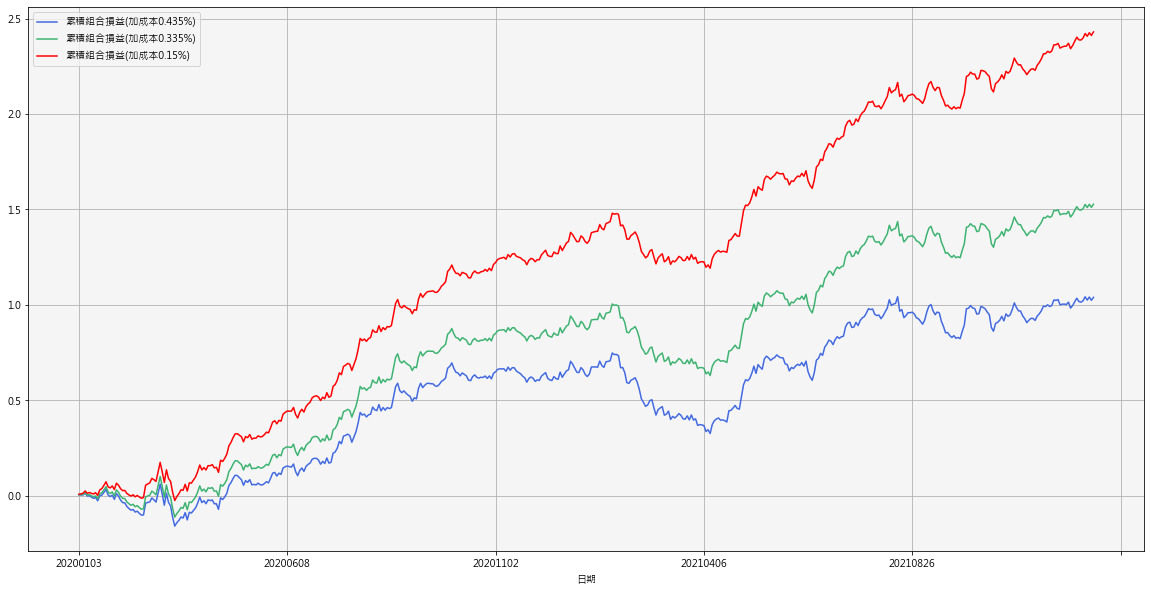

In [63]:
pool_combine[['累積組合損益(加成本0.435%)','累積組合損益(加成本0.335%)','累積組合損益(加成本0.15%)']].plot(figsize=(20, 10),color = ['royalblue','mediumseagreen','red'],grid = True)